In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [3]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 97% 993M/1.00G [00:10<00:00, 74.5MB/s]
100% 1.00G/1.00G [00:11<00:00, 94.5MB/s]
Dataset downloaded and extracted to /content/dataset/


In [4]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [5]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [6]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - d_loss: 0.4884 - g_loss: 0.7561

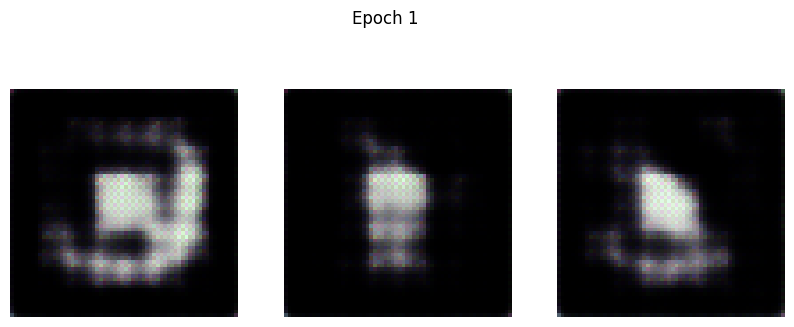

100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - d_loss: 0.4890 - g_loss: 0.7566
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - d_loss: 0.6713 - g_loss: 0.7297

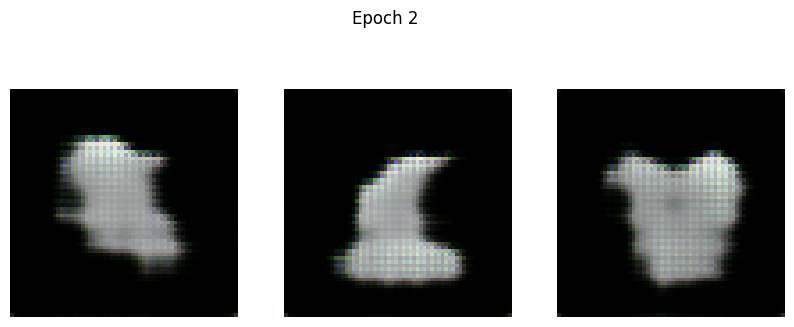

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - d_loss: 0.6714 - g_loss: 0.7296
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 0.6801 - g_loss: 0.6874

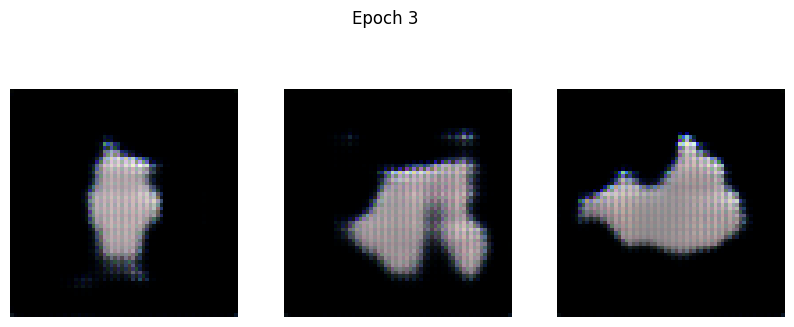

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - d_loss: 0.6800 - g_loss: 0.6875
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 0.6650 - g_loss: 0.7347

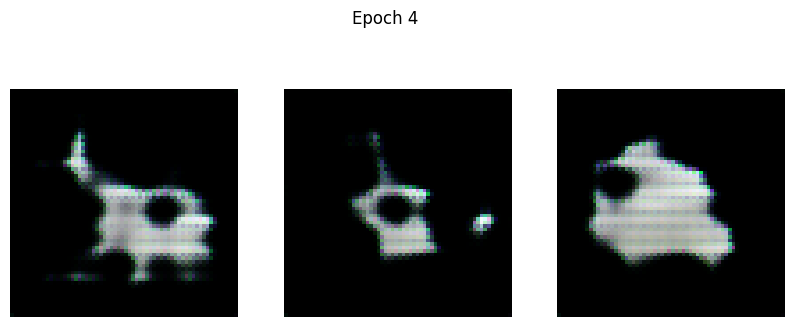

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - d_loss: 0.6650 - g_loss: 0.7348
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6598 - g_loss: 0.7555

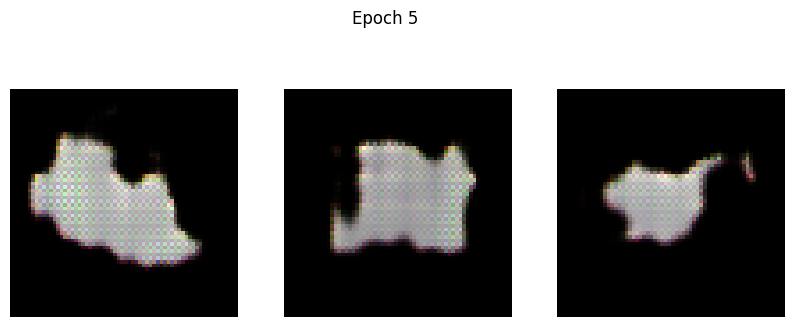

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6598 - g_loss: 0.7556
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6642 - g_loss: 0.7753

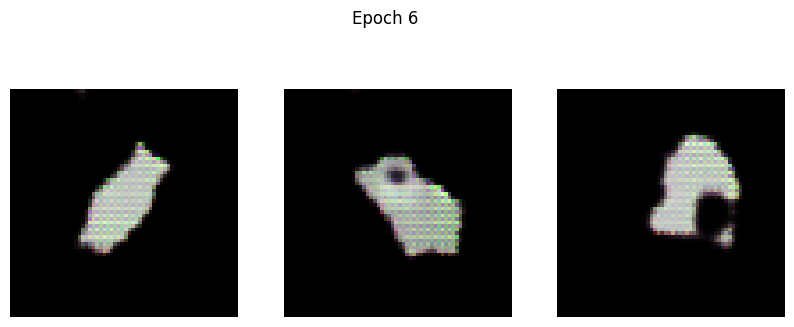

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6642 - g_loss: 0.7754
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6627 - g_loss: 0.7621

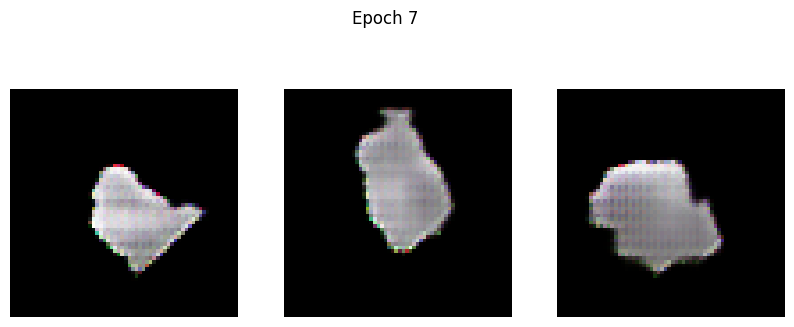

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6626 - g_loss: 0.7621
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6622 - g_loss: 0.7552

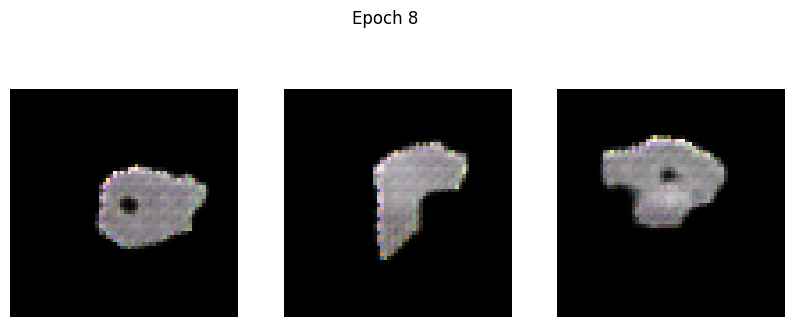

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6621 - g_loss: 0.7552
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6556 - g_loss: 0.7357

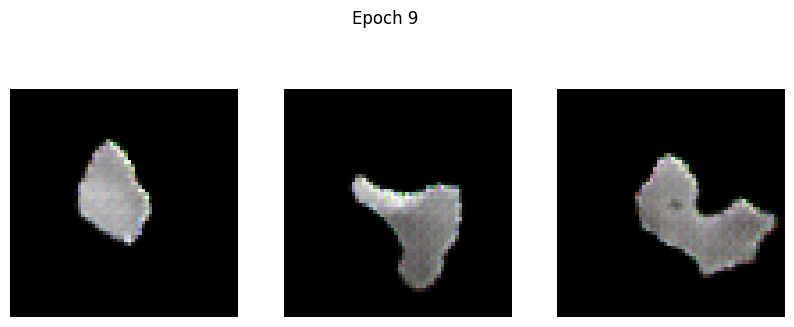

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6556 - g_loss: 0.7357
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6589 - g_loss: 0.7492

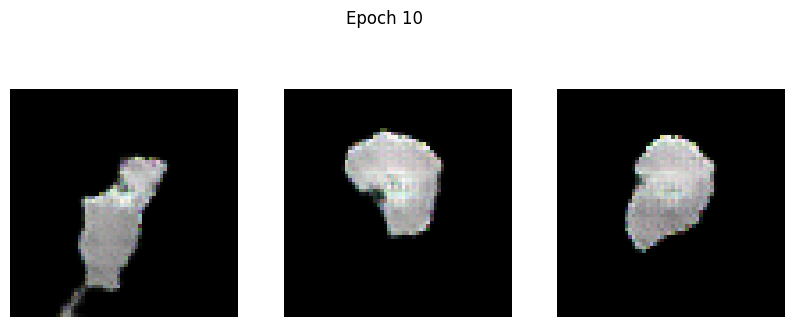

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6588 - g_loss: 0.7492
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6510 - g_loss: 0.7570

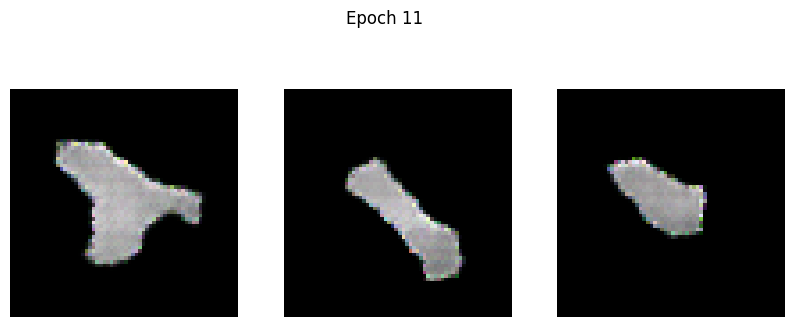

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6511 - g_loss: 0.7570
Epoch 12/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6510 - g_loss: 0.7727

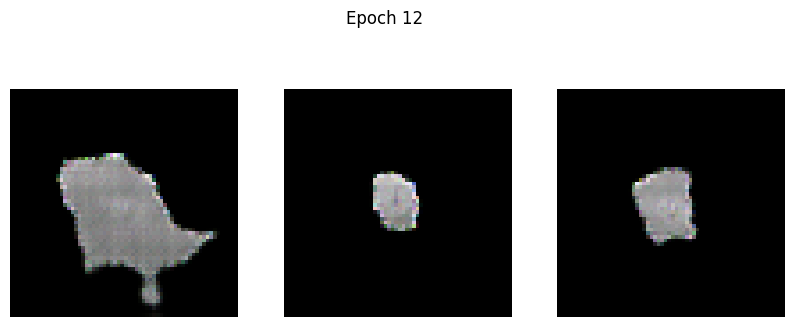

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6510 - g_loss: 0.7729
Epoch 13/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6405 - g_loss: 0.7903

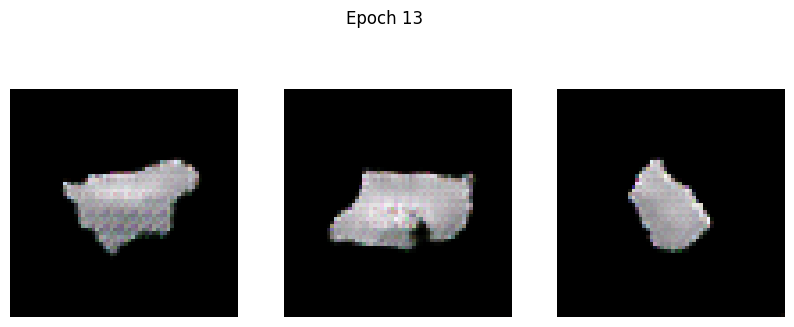

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6404 - g_loss: 0.7905
Epoch 14/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6319 - g_loss: 0.8478

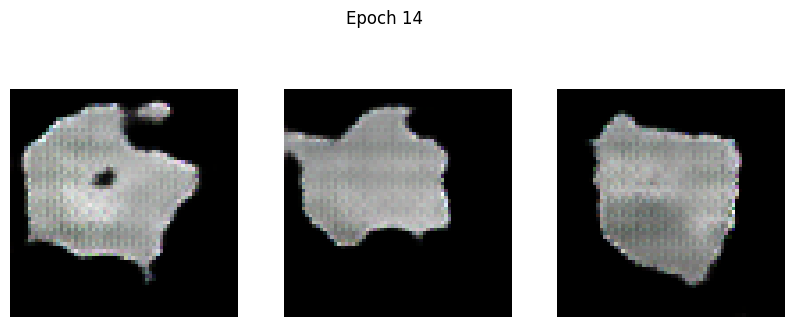

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6319 - g_loss: 0.8478
Epoch 15/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6180 - g_loss: 0.8146

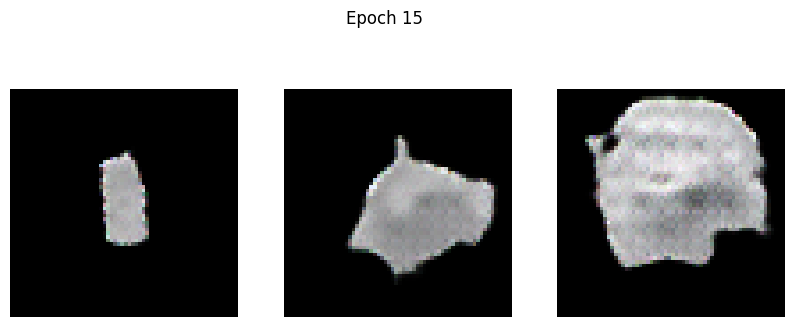

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6179 - g_loss: 0.8148
Epoch 16/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5931 - g_loss: 0.8822

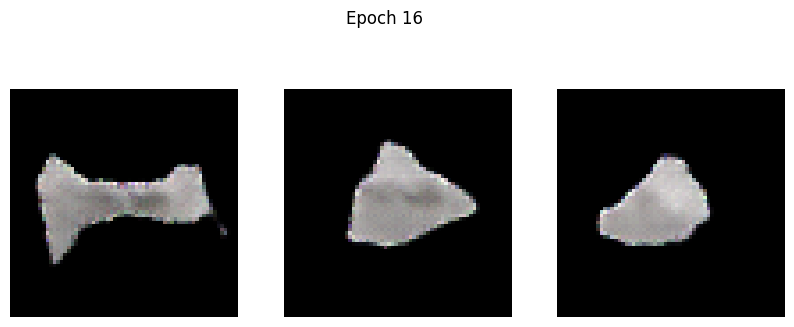

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5931 - g_loss: 0.8822
Epoch 17/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5860 - g_loss: 0.9317

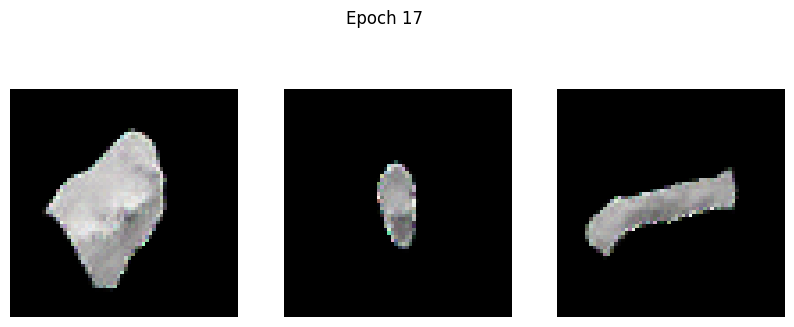

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5861 - g_loss: 0.9317
Epoch 18/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5925 - g_loss: 0.9283

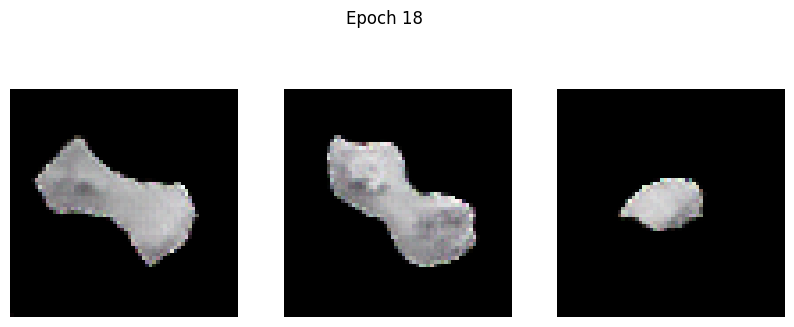

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5925 - g_loss: 0.9285
Epoch 19/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5662 - g_loss: 0.9232

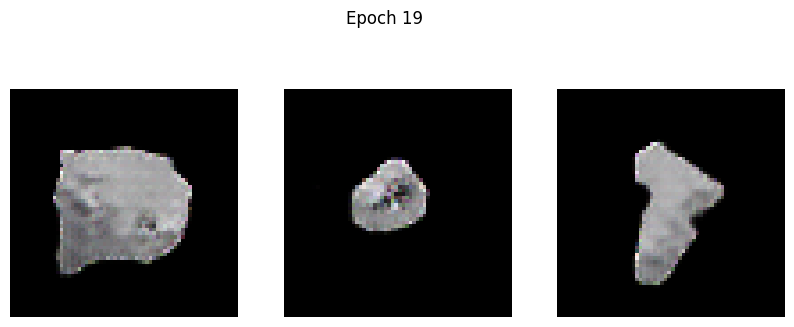

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5662 - g_loss: 0.9234
Epoch 20/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5889 - g_loss: 1.0240

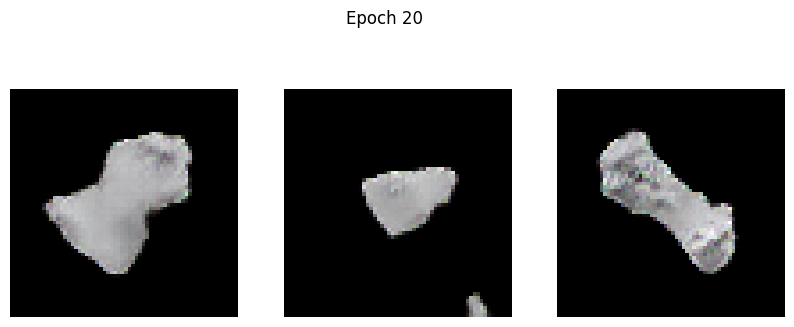

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5887 - g_loss: 1.0235
Epoch 21/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5497 - g_loss: 0.9822

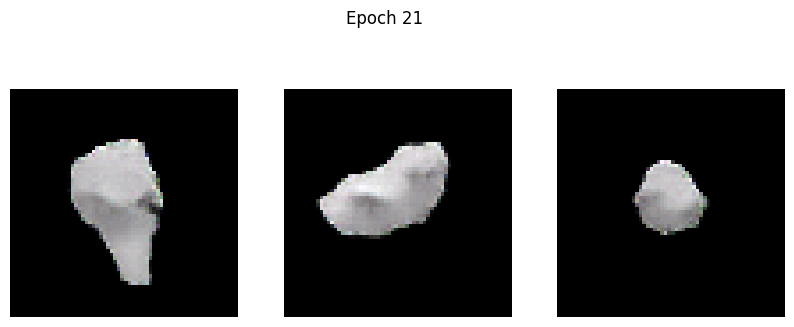

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5498 - g_loss: 0.9823
Epoch 22/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5521 - g_loss: 1.0495

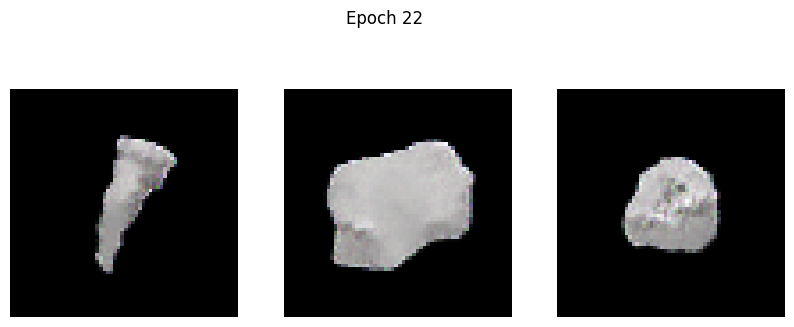

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5521 - g_loss: 1.0494
Epoch 23/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5301 - g_loss: 0.9941

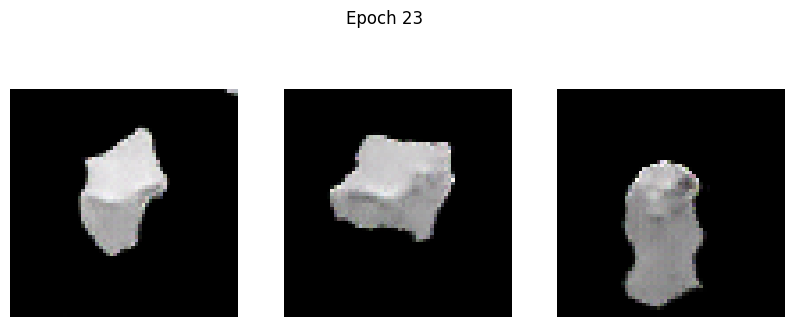

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.5300 - g_loss: 0.9944
Epoch 24/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5201 - g_loss: 1.0791

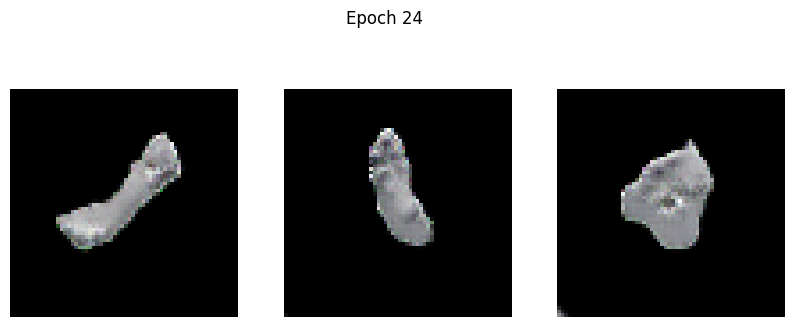

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5201 - g_loss: 1.0790
Epoch 25/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5201 - g_loss: 1.1013

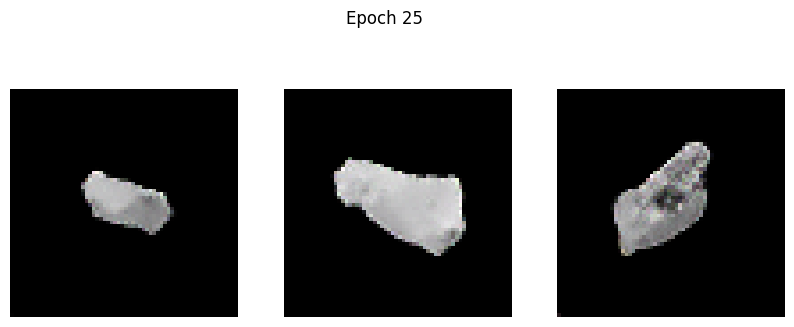

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5200 - g_loss: 1.1015
Epoch 26/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4759 - g_loss: 1.1448

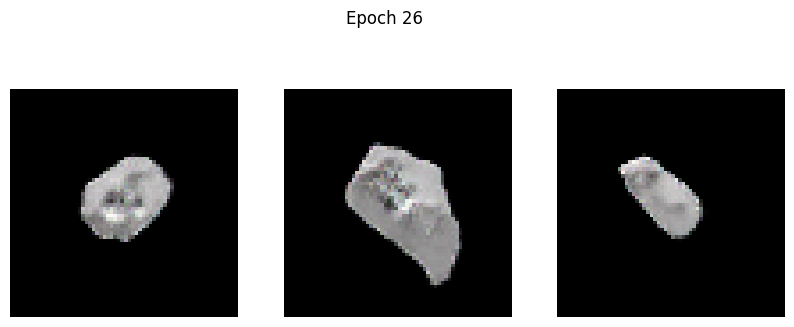

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4760 - g_loss: 1.1450
Epoch 27/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4911 - g_loss: 1.1997

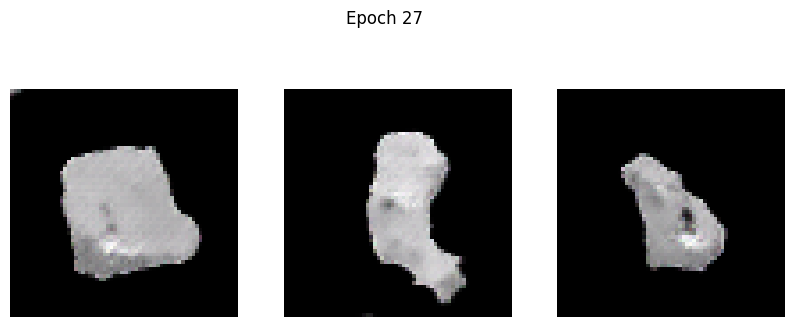

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4916 - g_loss: 1.2001
Epoch 28/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4819 - g_loss: 1.0777

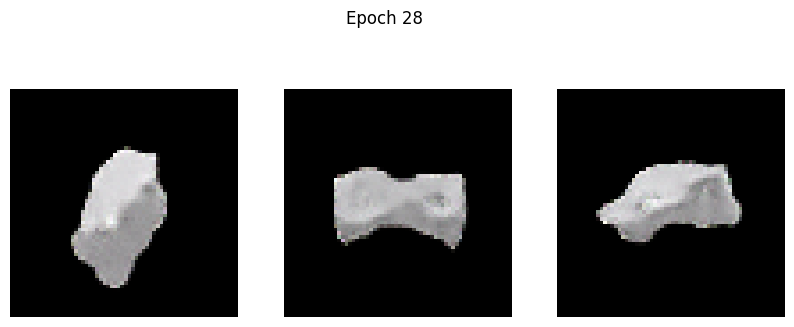

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4818 - g_loss: 1.0784
Epoch 29/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4557 - g_loss: 1.2286

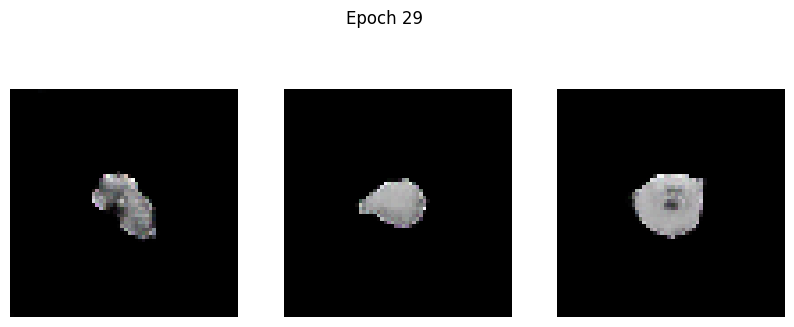

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4557 - g_loss: 1.2288
Epoch 30/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4380 - g_loss: 1.3126

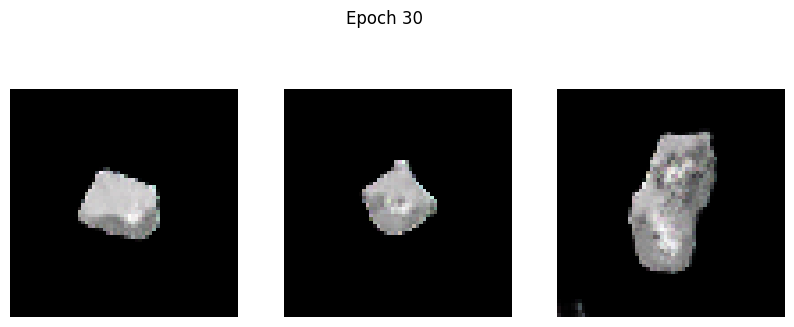

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4380 - g_loss: 1.3127
Epoch 31/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4262 - g_loss: 1.3909

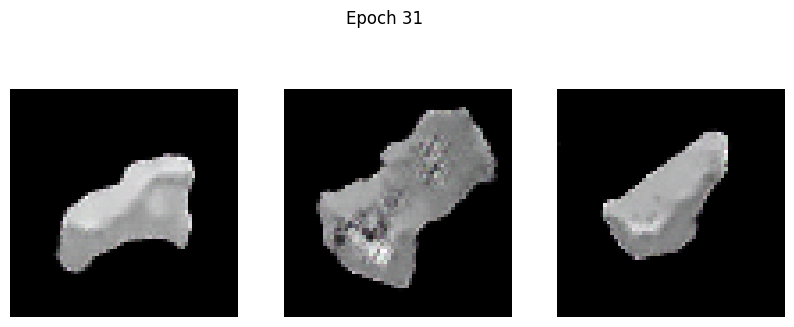

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4262 - g_loss: 1.3910
Epoch 32/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4117 - g_loss: 1.4019

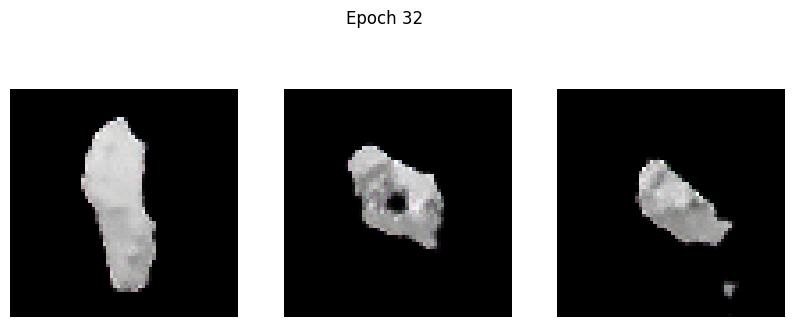

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4118 - g_loss: 1.4020
Epoch 33/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4125 - g_loss: 1.4199

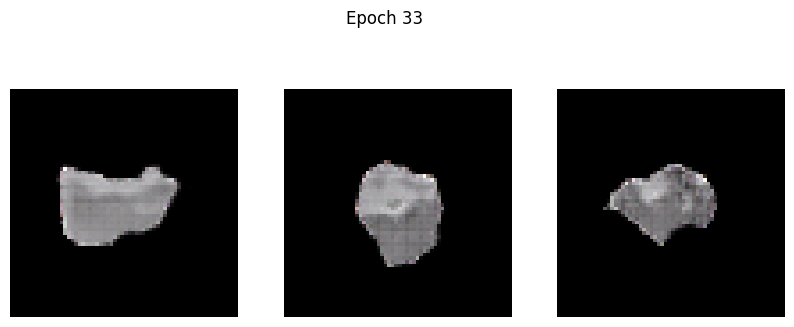

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4133 - g_loss: 1.4218
Epoch 34/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4610 - g_loss: 1.3906

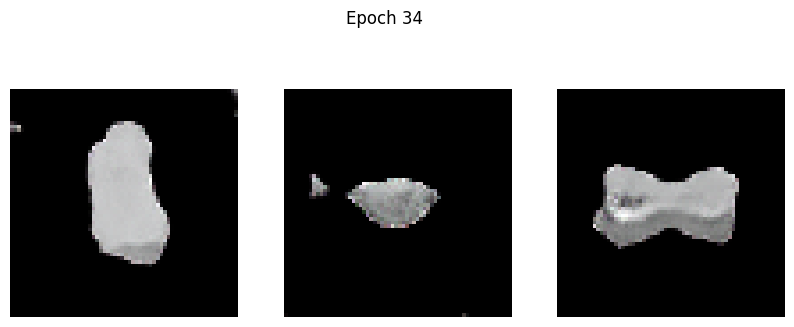

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4606 - g_loss: 1.3902
Epoch 35/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3664 - g_loss: 1.4040

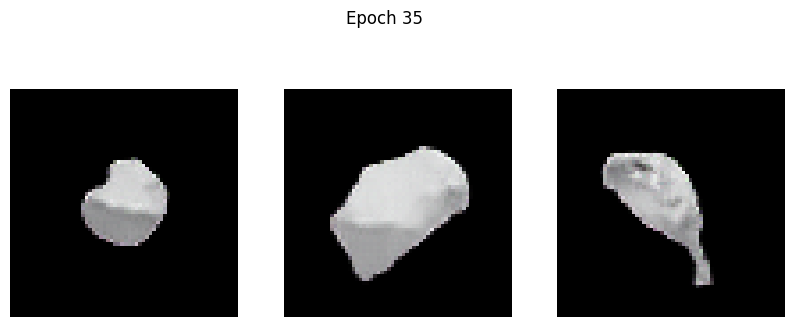

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3665 - g_loss: 1.4043
Epoch 36/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3887 - g_loss: 1.5555

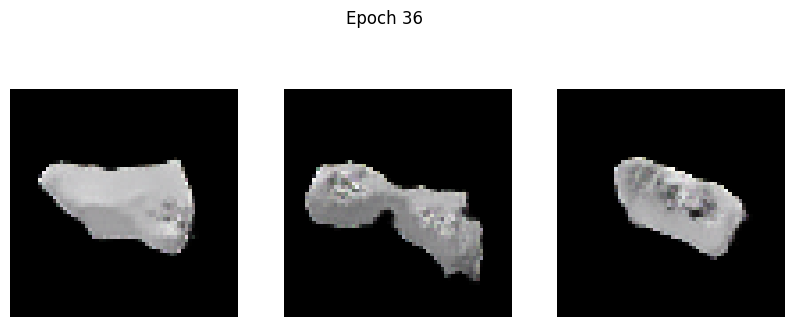

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3886 - g_loss: 1.5553
Epoch 37/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4096 - g_loss: 1.6082

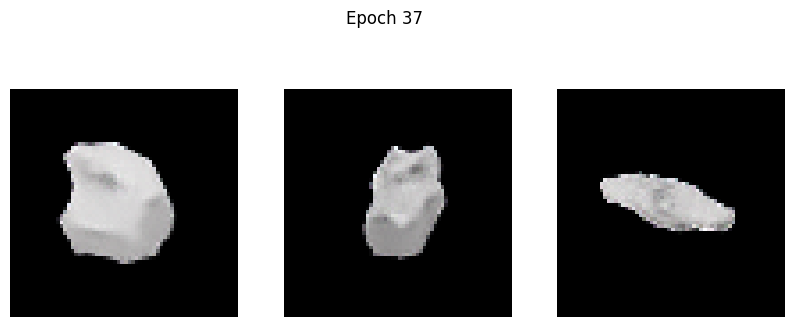

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4095 - g_loss: 1.6079
Epoch 38/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3759 - g_loss: 1.5820

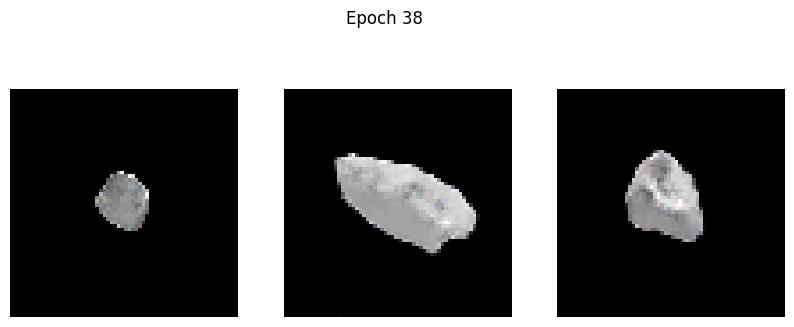

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3760 - g_loss: 1.5821
Epoch 39/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3509 - g_loss: 1.5748

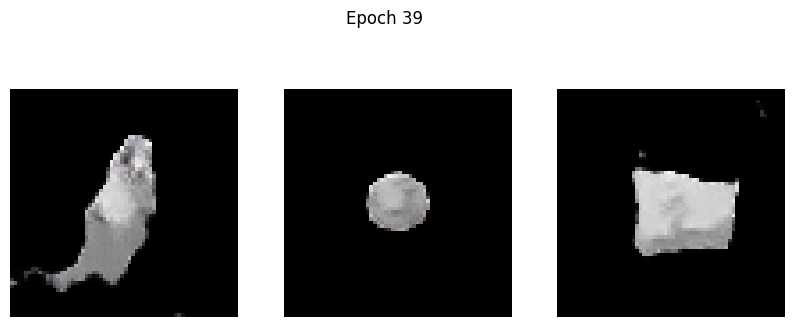

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3510 - g_loss: 1.5749
Epoch 40/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3564 - g_loss: 1.6555

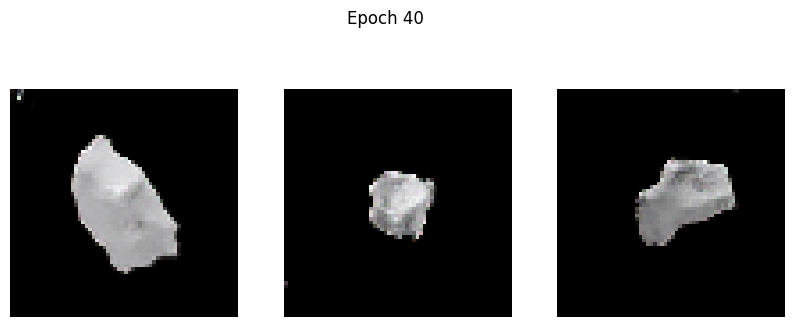

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3564 - g_loss: 1.6556
Epoch 41/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3749 - g_loss: 1.6585

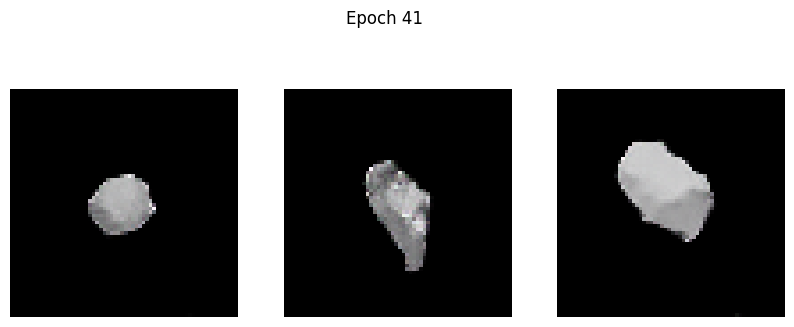

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3748 - g_loss: 1.6585
Epoch 42/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4265 - g_loss: 1.7962

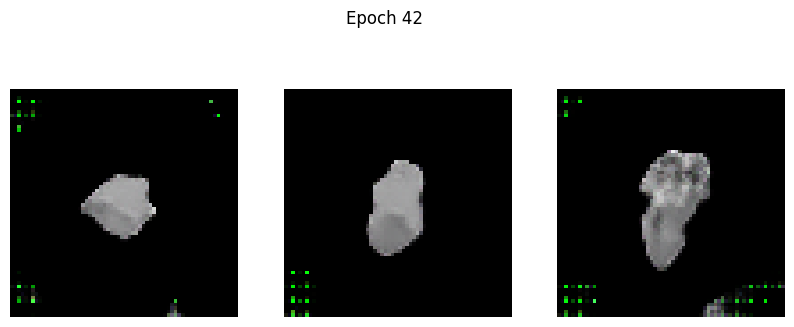

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4265 - g_loss: 1.7955
Epoch 43/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3809 - g_loss: 1.5943

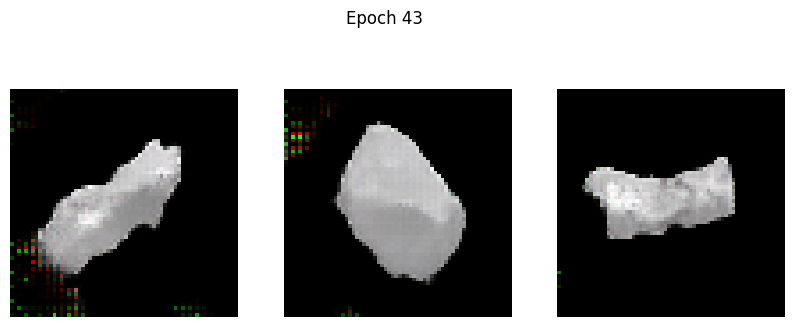

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3812 - g_loss: 1.5951
Epoch 44/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4318 - g_loss: 1.8105

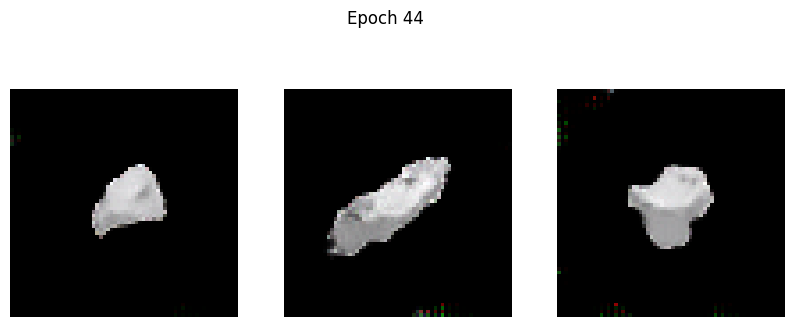

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4312 - g_loss: 1.8085
Epoch 45/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3484 - g_loss: 1.6428

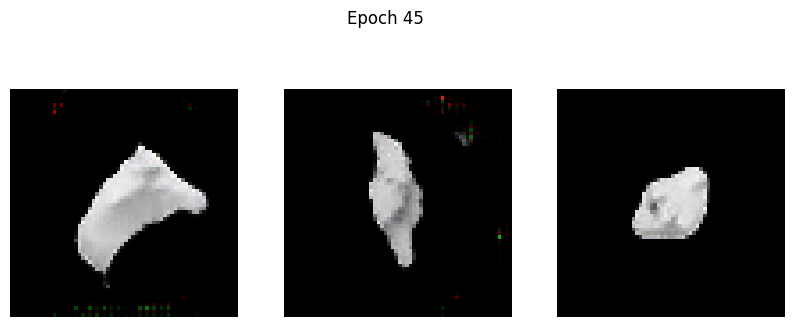

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3484 - g_loss: 1.6428
Epoch 46/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3583 - g_loss: 1.6857

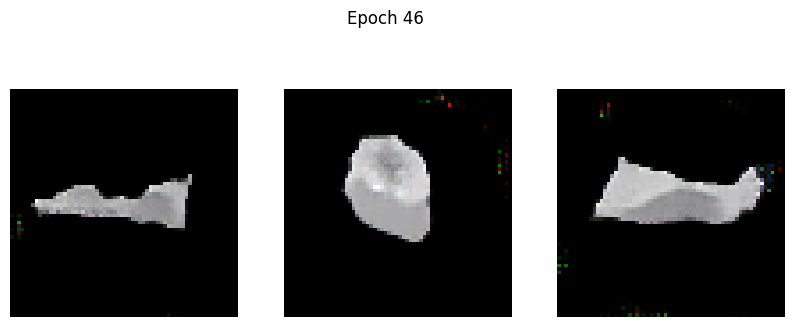

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3582 - g_loss: 1.6858
Epoch 47/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5031 - g_loss: 1.9631

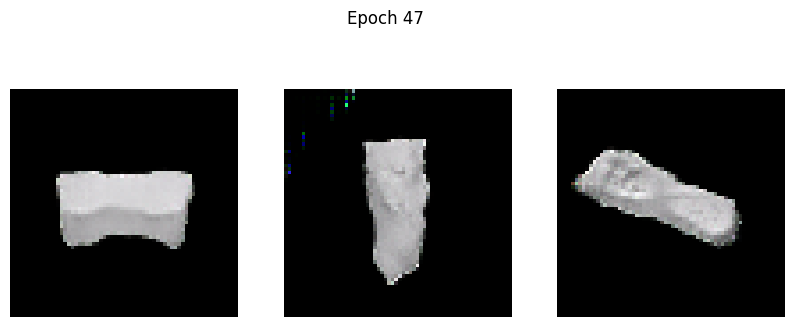

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5023 - g_loss: 1.9609
Epoch 48/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3393 - g_loss: 1.6727

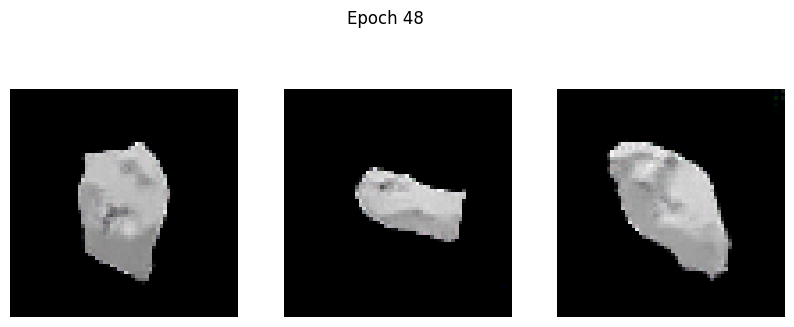

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3396 - g_loss: 1.6727
Epoch 49/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3445 - g_loss: 1.7051

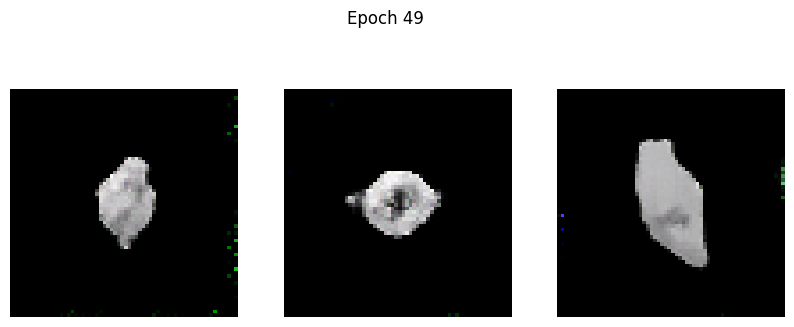

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3446 - g_loss: 1.7055
Epoch 50/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3334 - g_loss: 1.7375

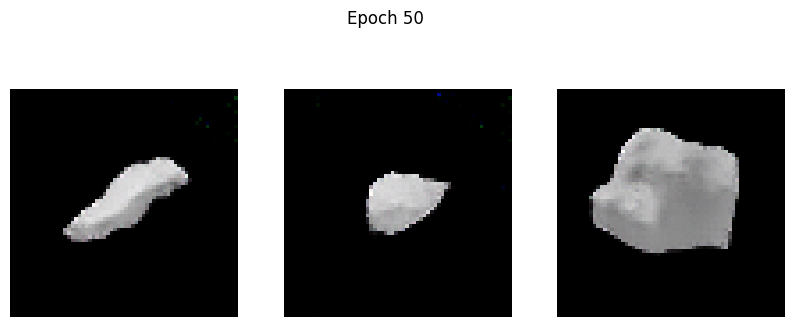

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3336 - g_loss: 1.7378
Epoch 51/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3200 - g_loss: 1.7053

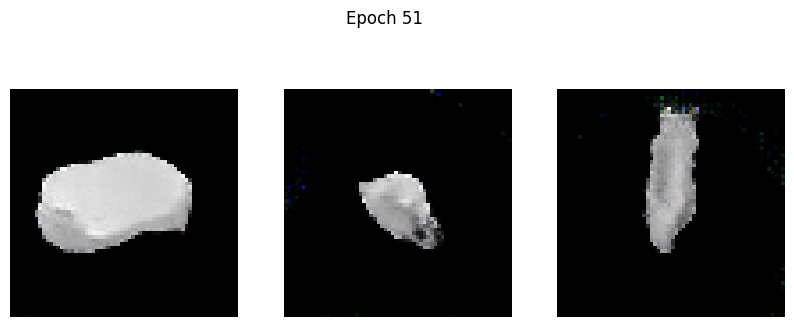

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3201 - g_loss: 1.7059
Epoch 52/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3441 - g_loss: 1.8282

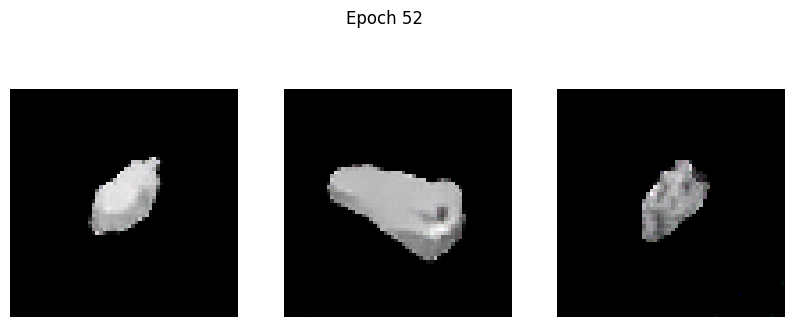

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3441 - g_loss: 1.8277
Epoch 53/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3491 - g_loss: 1.8694

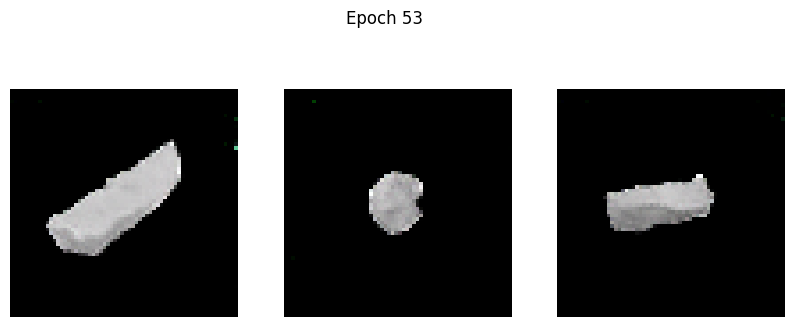

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3491 - g_loss: 1.8692
Epoch 54/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3233 - g_loss: 1.8204

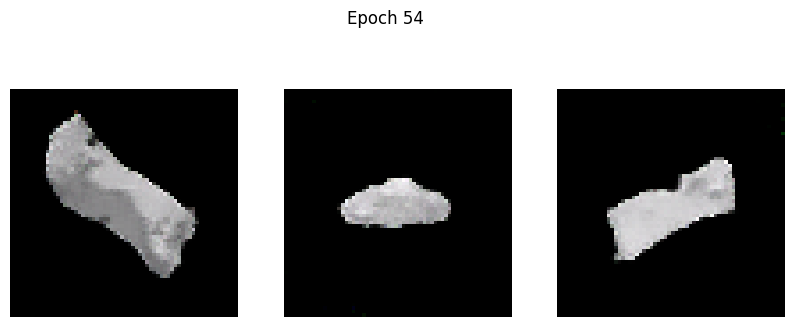

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3234 - g_loss: 1.8205
Epoch 55/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3709 - g_loss: 1.8915

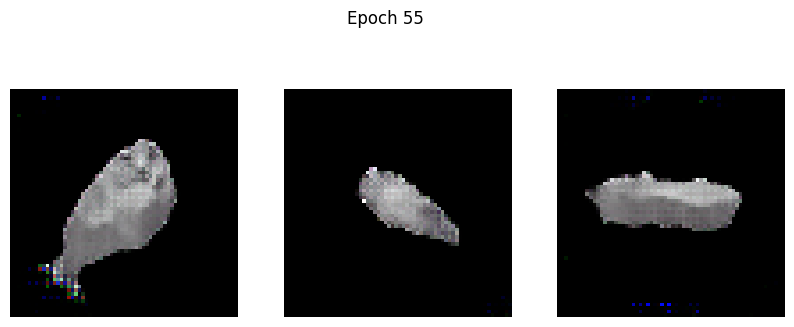

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3725 - g_loss: 1.8932
Epoch 56/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3489 - g_loss: 1.5757

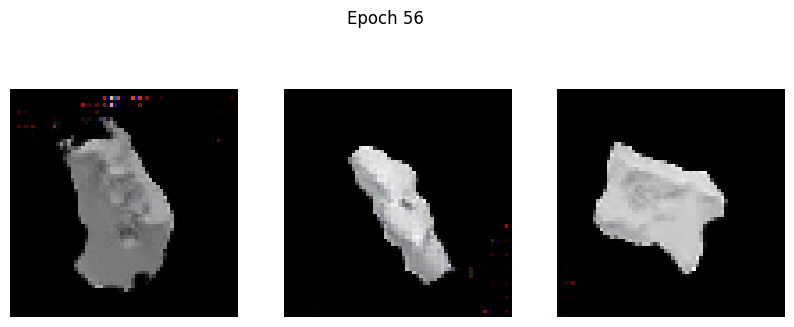

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3487 - g_loss: 1.5761
Epoch 57/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3134 - g_loss: 1.7229

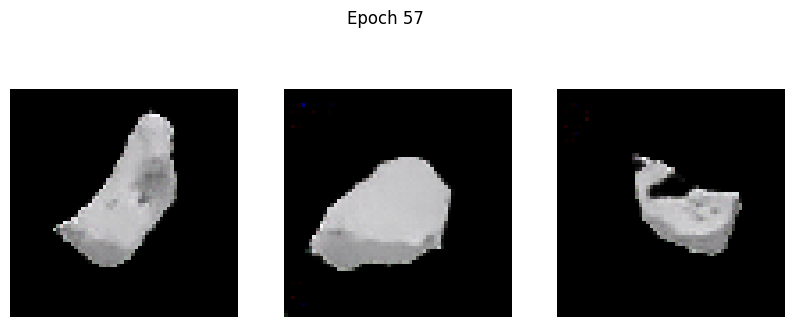

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3136 - g_loss: 1.7229
Epoch 58/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3118 - g_loss: 1.8075

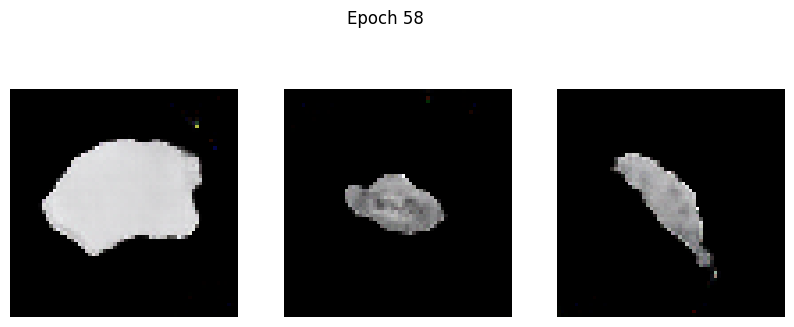

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3118 - g_loss: 1.8075
Epoch 59/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3112 - g_loss: 1.8583

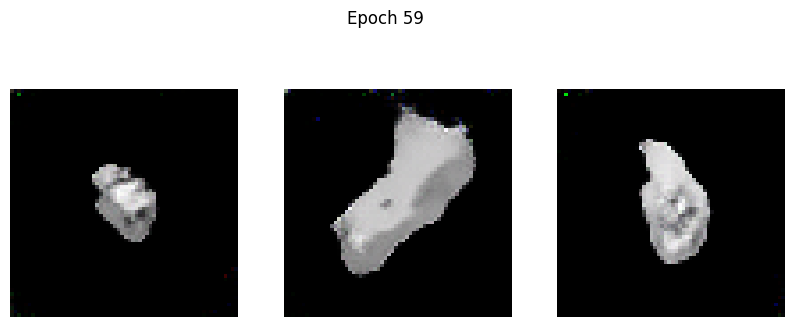

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3112 - g_loss: 1.8583
Epoch 60/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2746 - g_loss: 1.8754

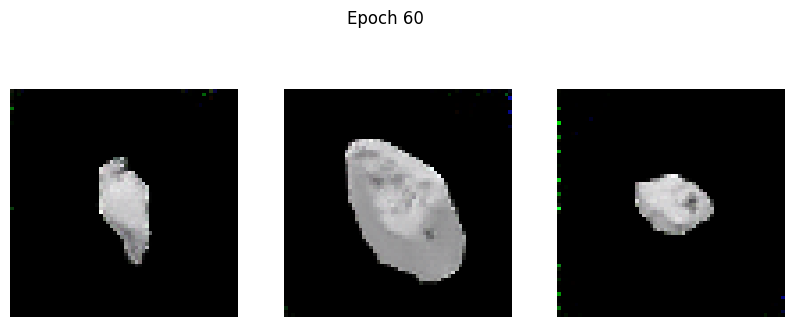

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2747 - g_loss: 1.8755
Epoch 61/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4344 - g_loss: 2.1211

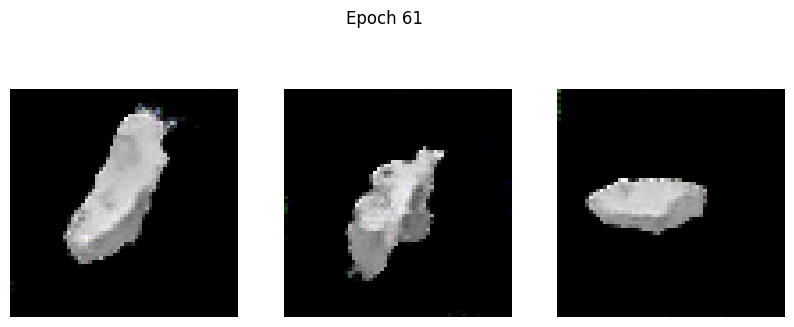

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4354 - g_loss: 2.1219
Epoch 62/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3247 - g_loss: 1.6489

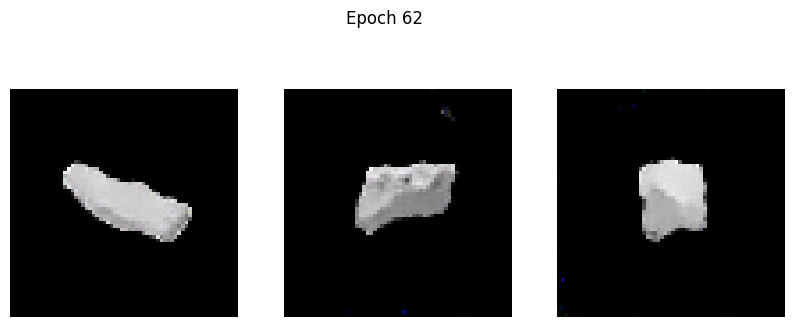

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3246 - g_loss: 1.6492
Epoch 63/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3302 - g_loss: 1.7972

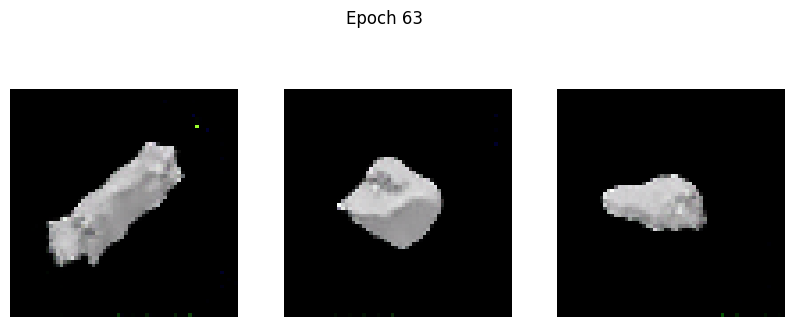

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3300 - g_loss: 1.7971
Epoch 64/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2993 - g_loss: 1.8239

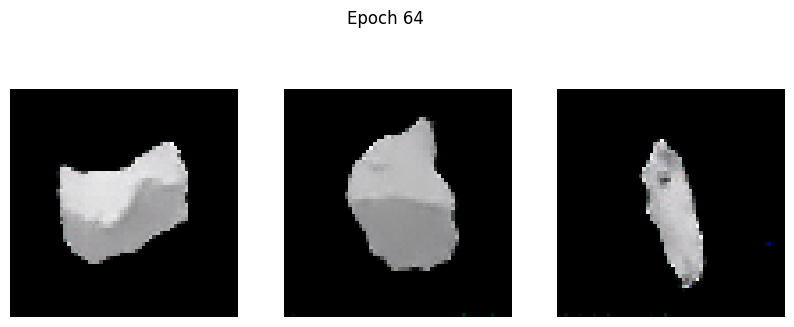

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2993 - g_loss: 1.8242
Epoch 65/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2897 - g_loss: 1.8191

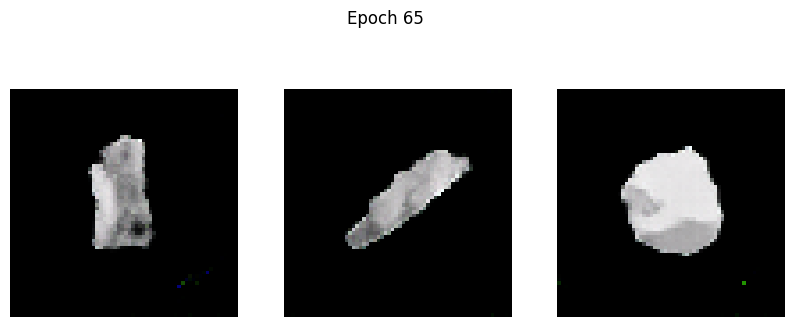

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2896 - g_loss: 1.8198
Epoch 66/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4061 - g_loss: 2.1057

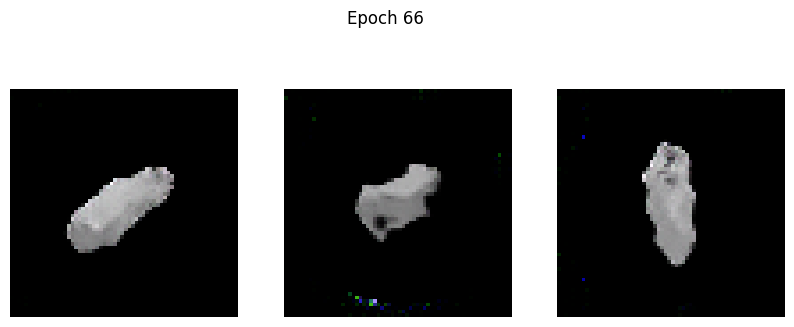

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4059 - g_loss: 2.1049
Epoch 67/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2870 - g_loss: 1.8705

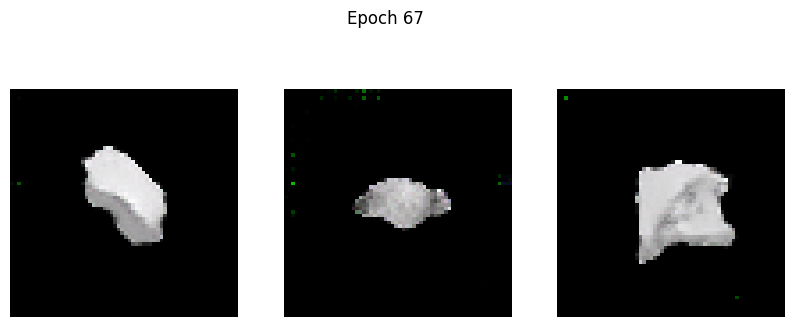

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2870 - g_loss: 1.8705
Epoch 68/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3062 - g_loss: 1.9556

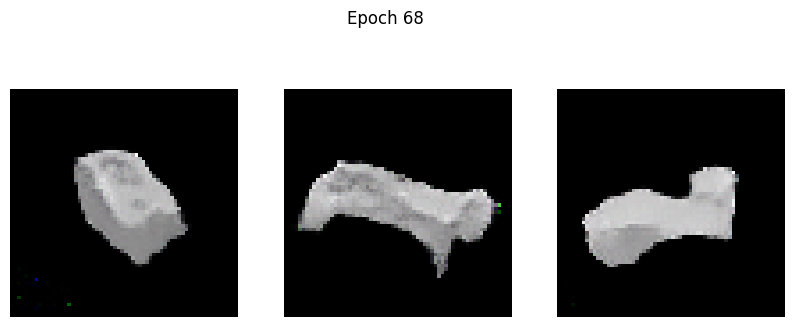

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3064 - g_loss: 1.9561
Epoch 69/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2937 - g_loss: 1.9670

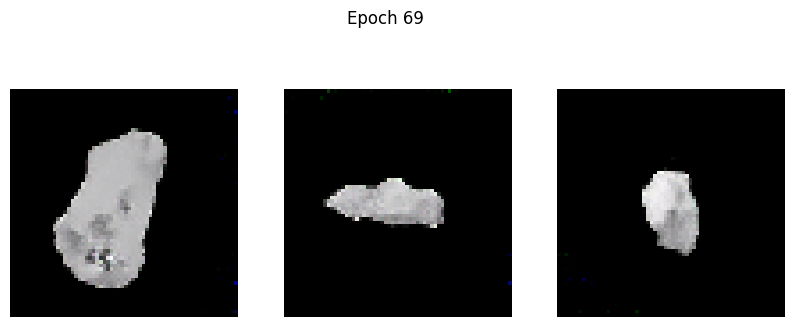

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2937 - g_loss: 1.9670
Epoch 70/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2744 - g_loss: 1.9198

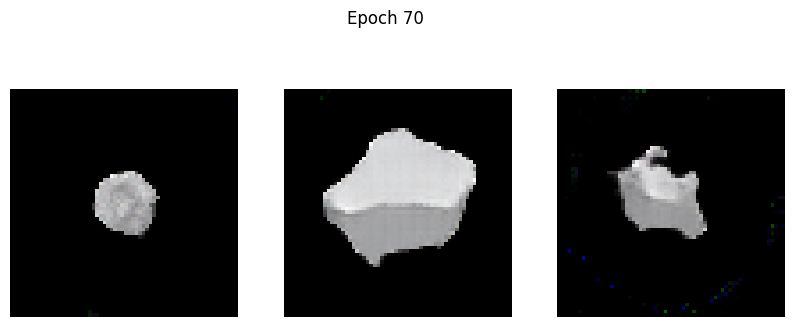

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2746 - g_loss: 1.9204
Epoch 71/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3327 - g_loss: 2.1677

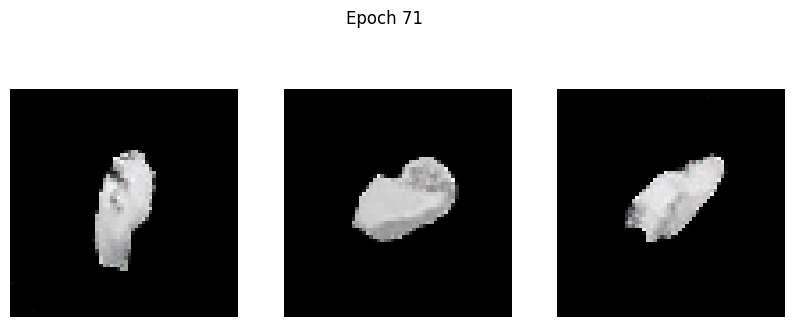

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3329 - g_loss: 2.1676
Epoch 72/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2500 - g_loss: 1.9227

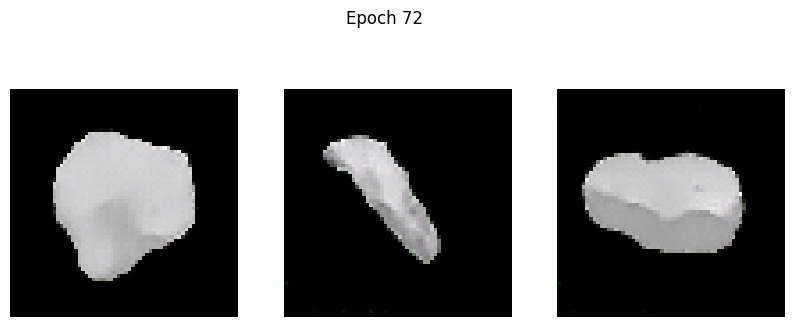

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2503 - g_loss: 1.9231
Epoch 73/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2911 - g_loss: 2.0439

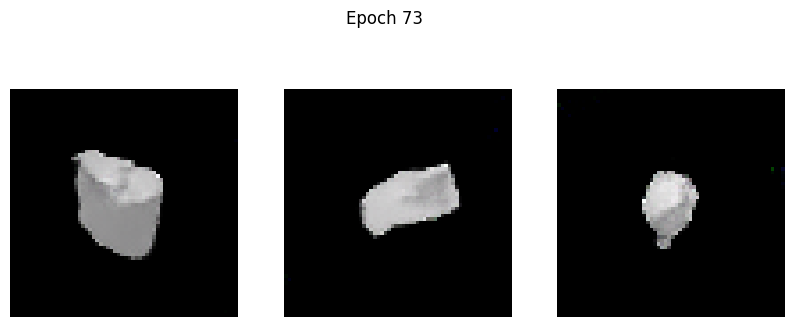

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2912 - g_loss: 2.0438
Epoch 74/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3037 - g_loss: 2.0180

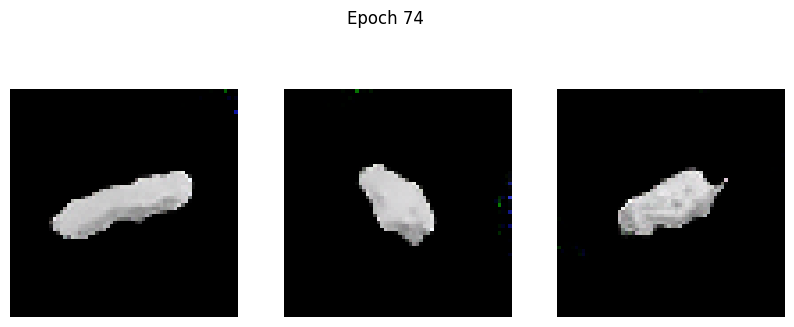

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3036 - g_loss: 2.0179
Epoch 75/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2549 - g_loss: 2.0991

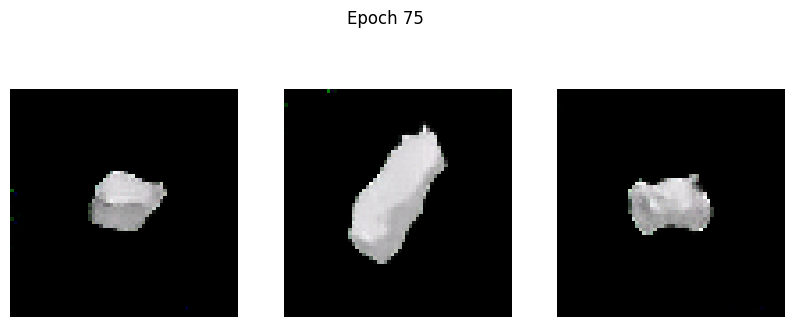

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2551 - g_loss: 2.0992
Epoch 76/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2759 - g_loss: 2.0477

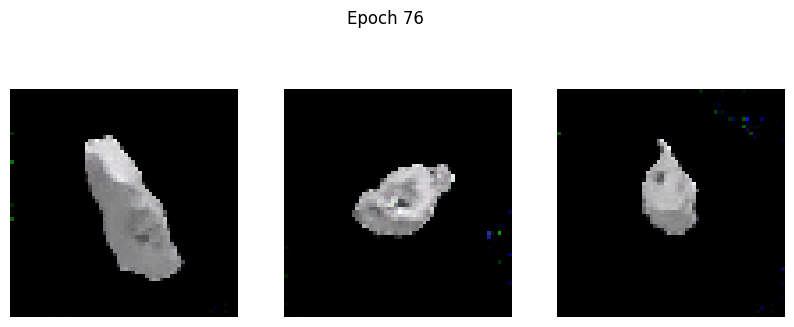

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2759 - g_loss: 2.0481
Epoch 77/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2736 - g_loss: 2.0527

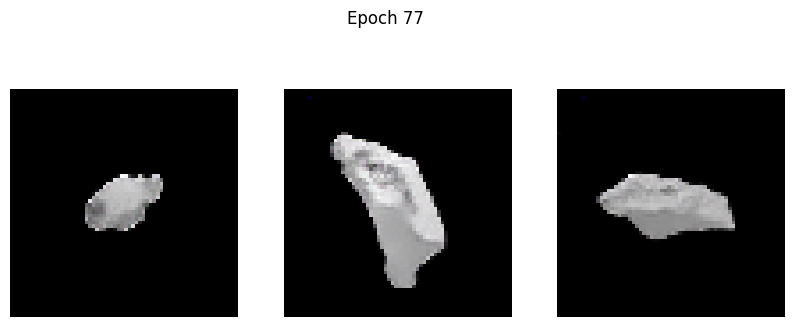

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2736 - g_loss: 2.0529
Epoch 78/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2480 - g_loss: 2.1148

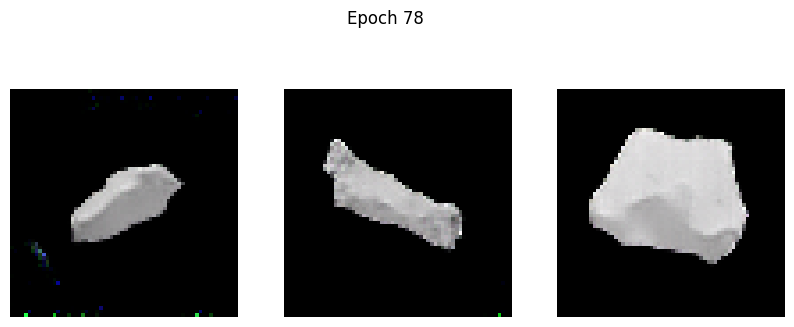

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2482 - g_loss: 2.1149
Epoch 79/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4243 - g_loss: 2.5588

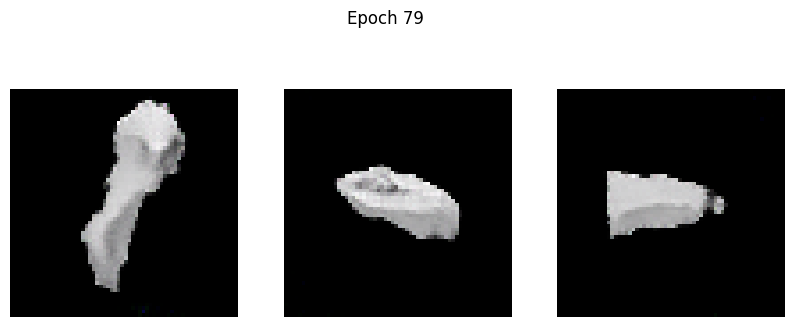

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4242 - g_loss: 2.5580
Epoch 80/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2426 - g_loss: 1.9993

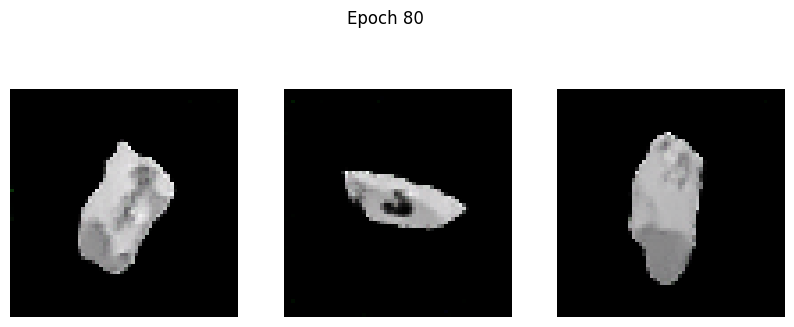

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2426 - g_loss: 1.9995
Epoch 81/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2369 - g_loss: 2.0880

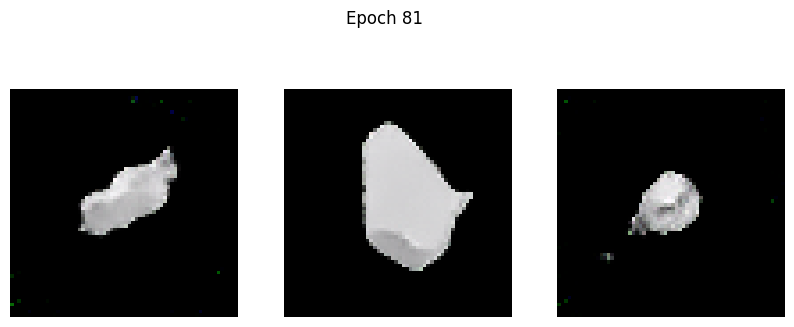

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2370 - g_loss: 2.0881
Epoch 82/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2772 - g_loss: 2.1499

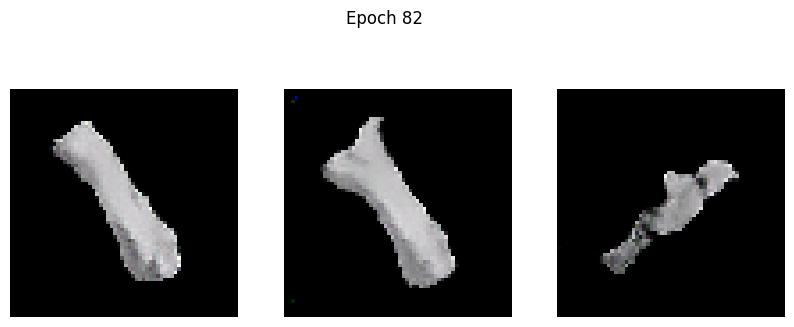

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2773 - g_loss: 2.1501
Epoch 83/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2317 - g_loss: 2.1721

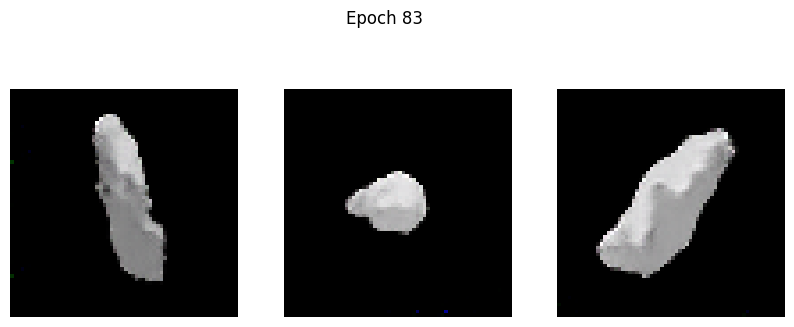

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2318 - g_loss: 2.1721
Epoch 84/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2744 - g_loss: 2.2526

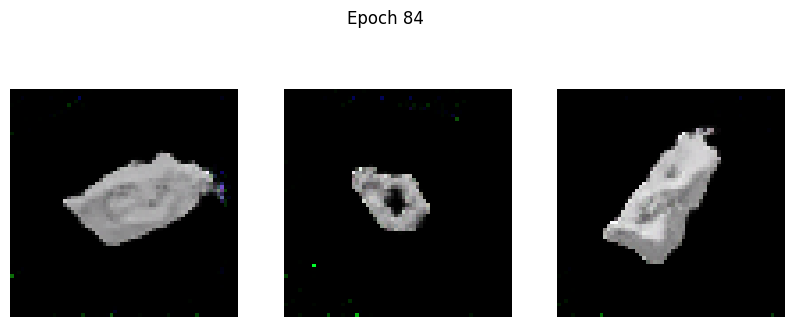

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2743 - g_loss: 2.2524
Epoch 85/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2486 - g_loss: 2.2023

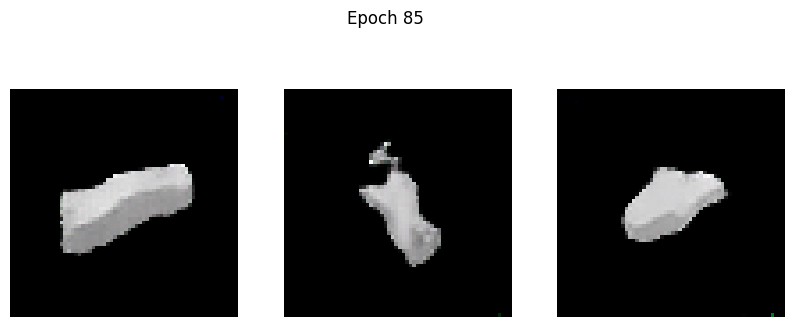

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2486 - g_loss: 2.2026
Epoch 86/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2657 - g_loss: 2.3196

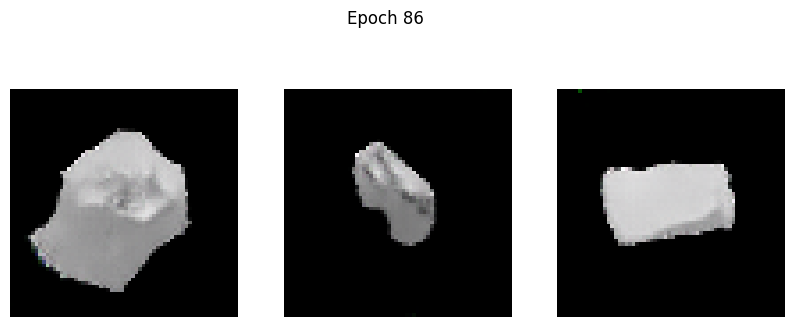

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2665 - g_loss: 2.3204
Epoch 87/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2706 - g_loss: 2.1924

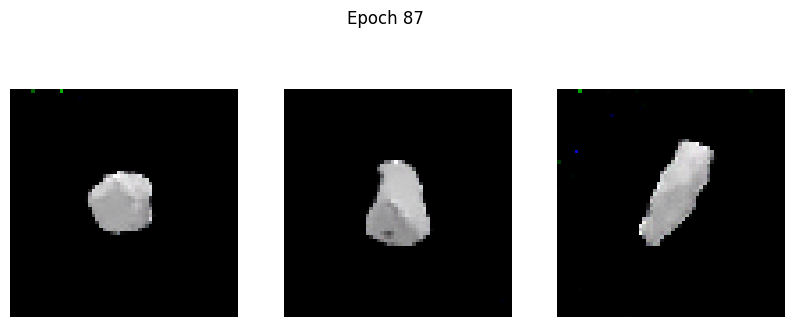

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2705 - g_loss: 2.1921
Epoch 88/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2375 - g_loss: 2.1749

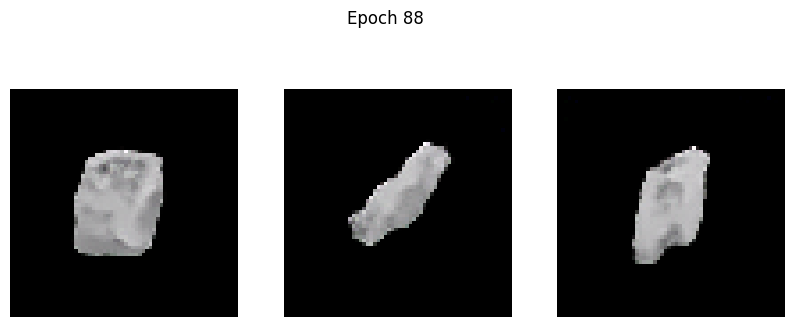

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2373 - g_loss: 2.1749
Epoch 89/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3096 - g_loss: 2.3710

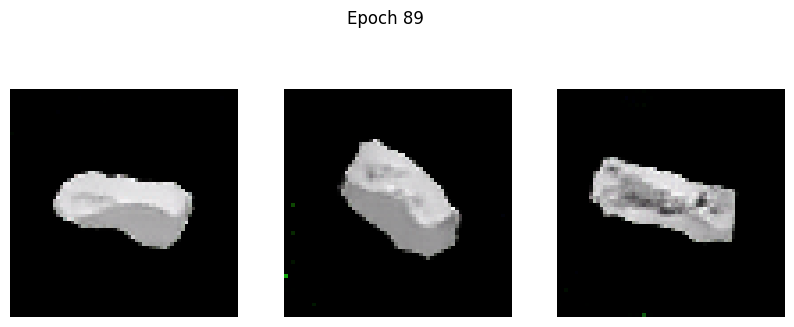

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.3095 - g_loss: 2.3706
Epoch 90/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2215 - g_loss: 2.2310

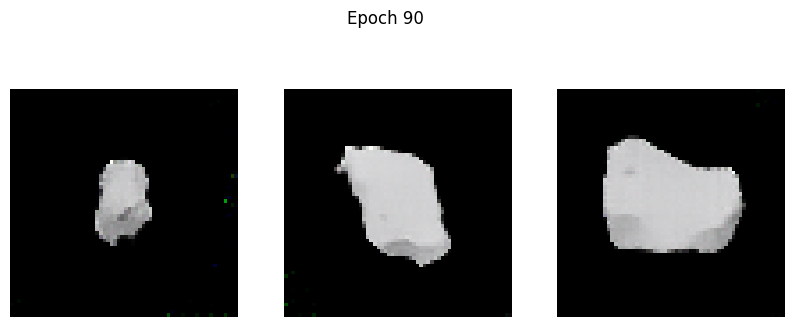

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2216 - g_loss: 2.2312
Epoch 91/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2502 - g_loss: 2.3923

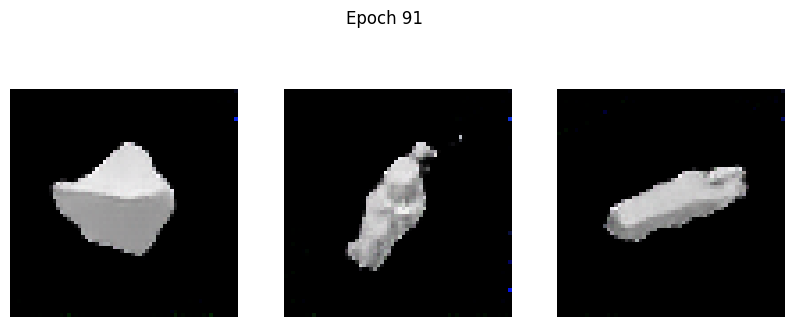

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2504 - g_loss: 2.3921
Epoch 92/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2314 - g_loss: 2.2926

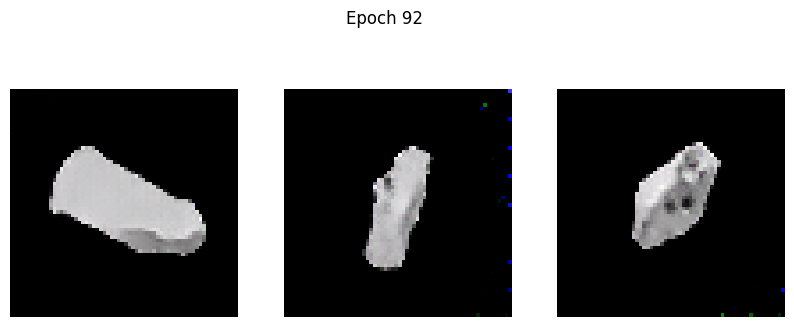

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2319 - g_loss: 2.2930
Epoch 93/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2479 - g_loss: 2.3407

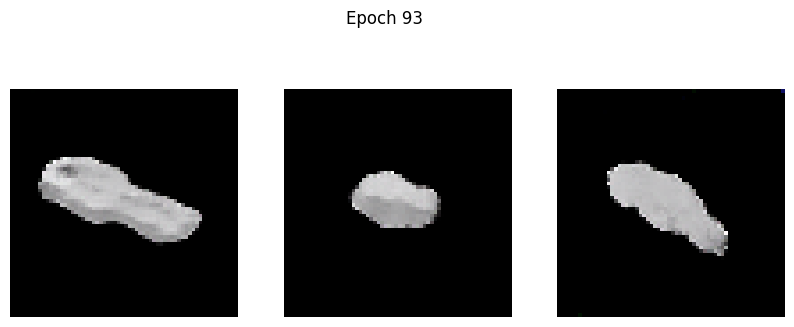

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2478 - g_loss: 2.3403
Epoch 94/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2373 - g_loss: 2.3869

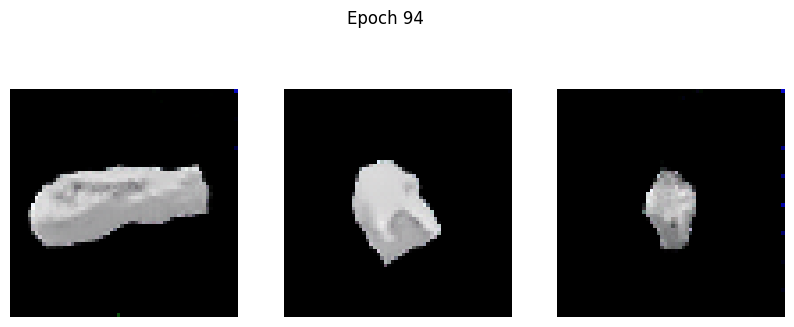

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2375 - g_loss: 2.3868
Epoch 95/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2248 - g_loss: 2.3518

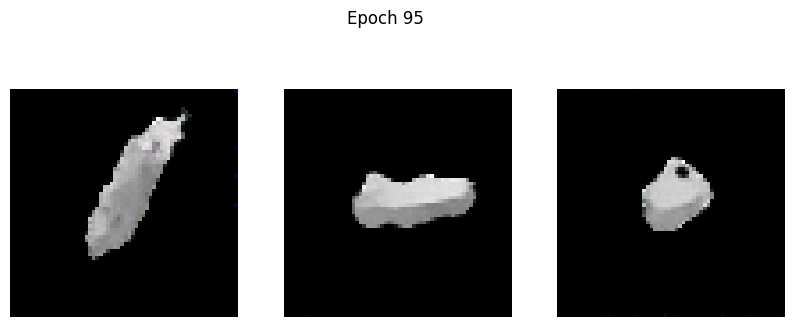

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2249 - g_loss: 2.3520
Epoch 96/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2205 - g_loss: 2.3235

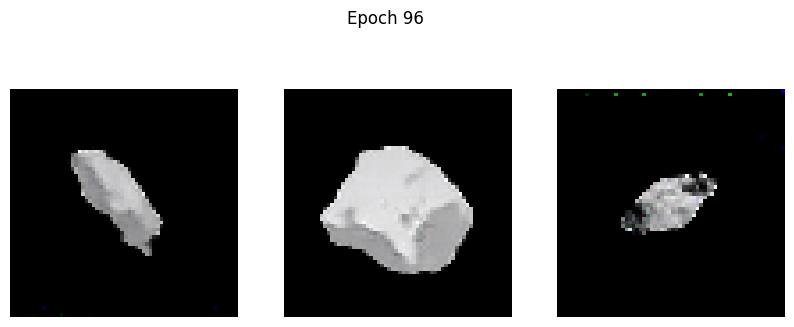

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2208 - g_loss: 2.3238
Epoch 97/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2517 - g_loss: 2.3813

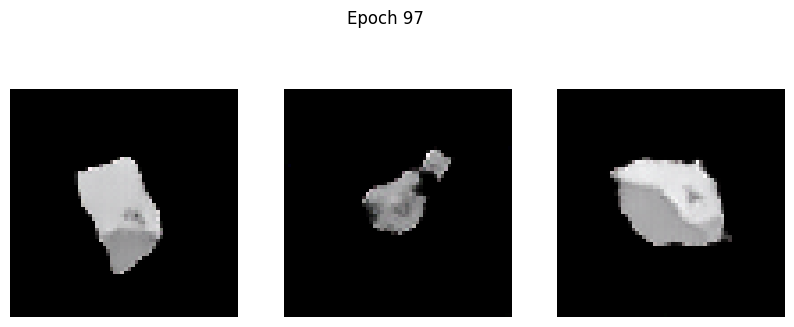

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2523 - g_loss: 2.3818
Epoch 98/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2254 - g_loss: 2.3267

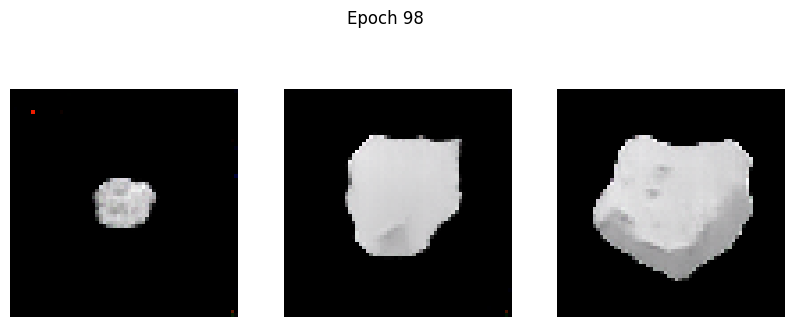

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2252 - g_loss: 2.3264
Epoch 99/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2223 - g_loss: 2.4069

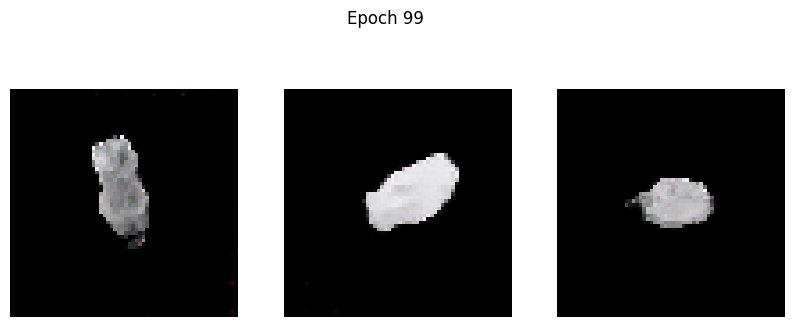

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2226 - g_loss: 2.4074
Epoch 100/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2043 - g_loss: 2.4283

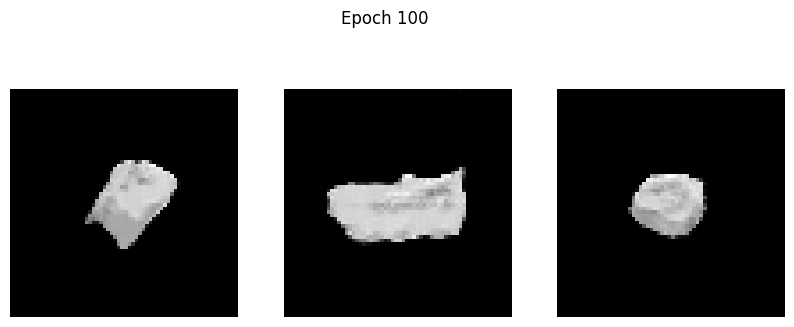

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2046 - g_loss: 2.4287
Epoch 101/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3072 - g_loss: 2.5587

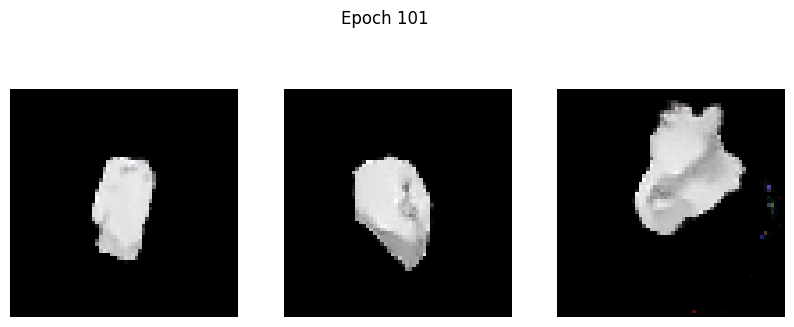

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3065 - g_loss: 2.5573
Epoch 102/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2554 - g_loss: 2.4852

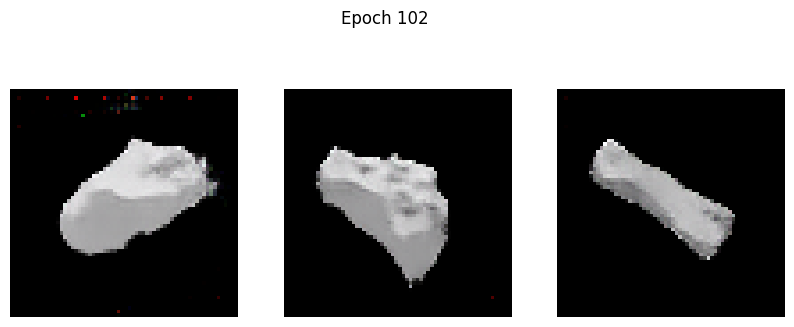

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2554 - g_loss: 2.4850
Epoch 103/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2489 - g_loss: 2.4175

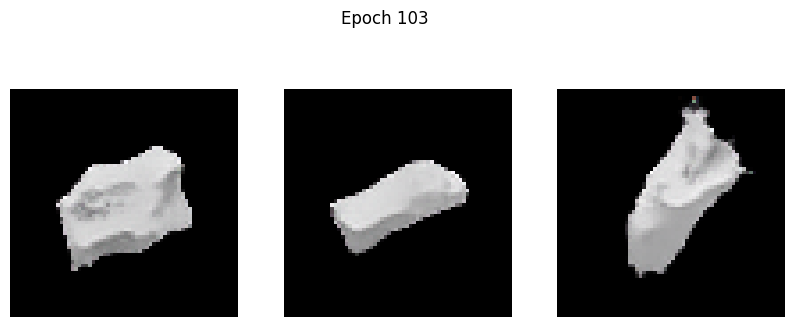

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2487 - g_loss: 2.4173
Epoch 104/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2484 - g_loss: 2.4448

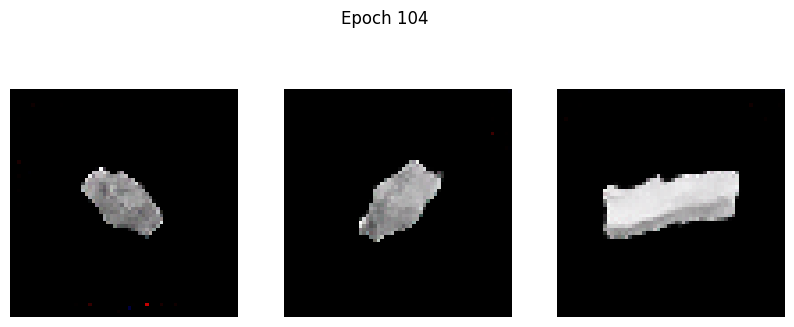

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2482 - g_loss: 2.4449
Epoch 105/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2404 - g_loss: 2.5651

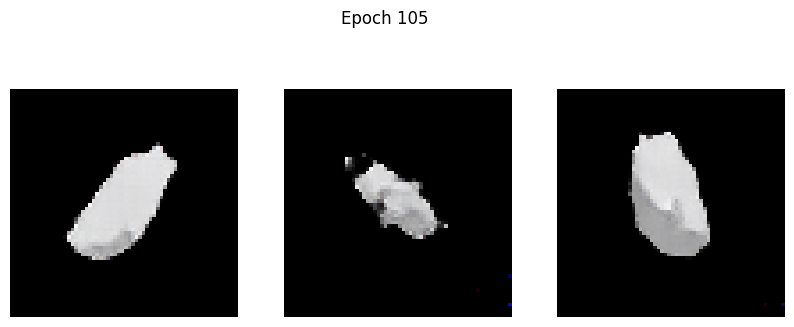

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2404 - g_loss: 2.5646
Epoch 106/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2414 - g_loss: 2.5249

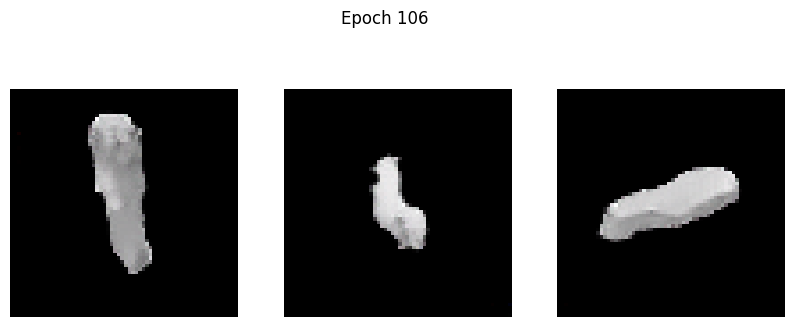

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2417 - g_loss: 2.5255
Epoch 107/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2068 - g_loss: 2.5263

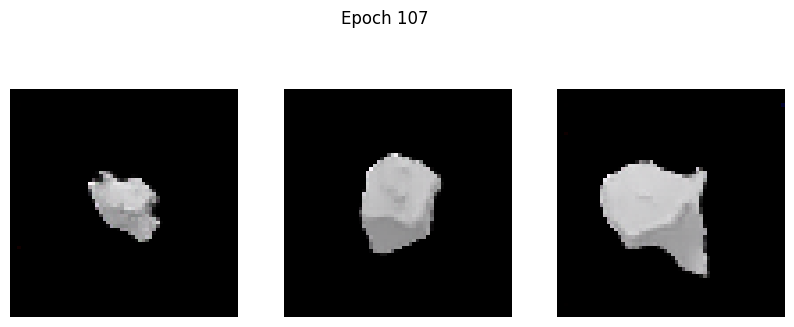

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.2068 - g_loss: 2.5260
Epoch 108/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2261 - g_loss: 2.4873

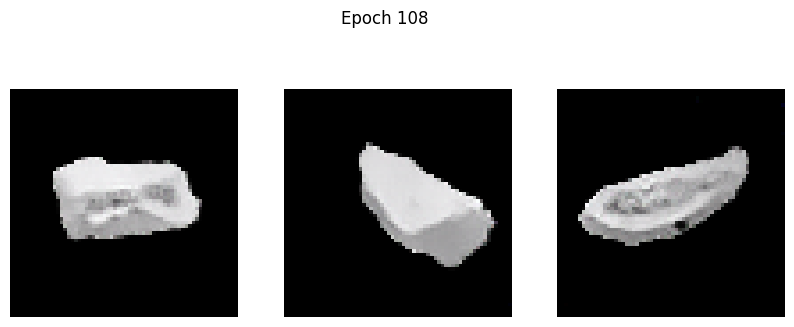

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2267 - g_loss: 2.4884
Epoch 109/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.1748 - g_loss: 2.4992

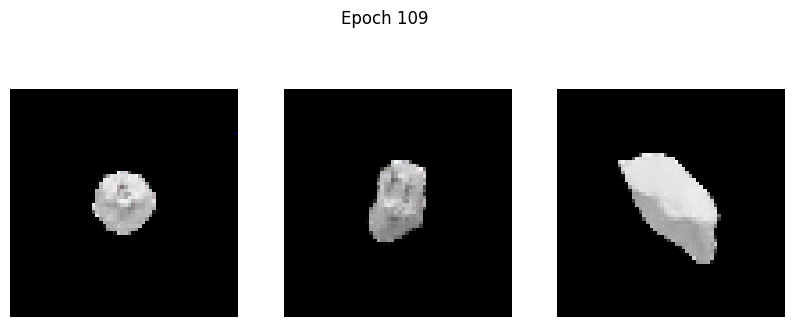

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.1750 - g_loss: 2.4993
Epoch 110/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1788 - g_loss: 2.5482

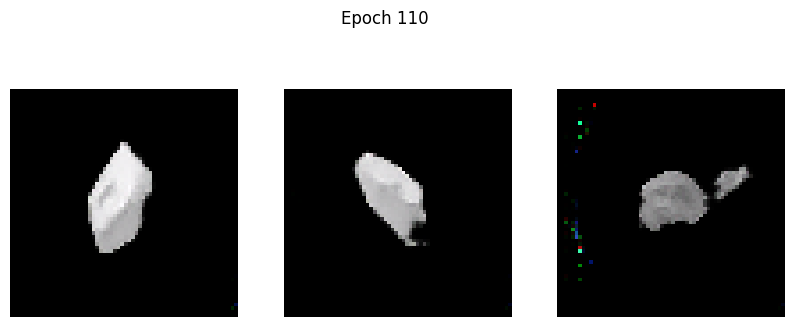

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1790 - g_loss: 2.5481
Epoch 111/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2261 - g_loss: 2.6700

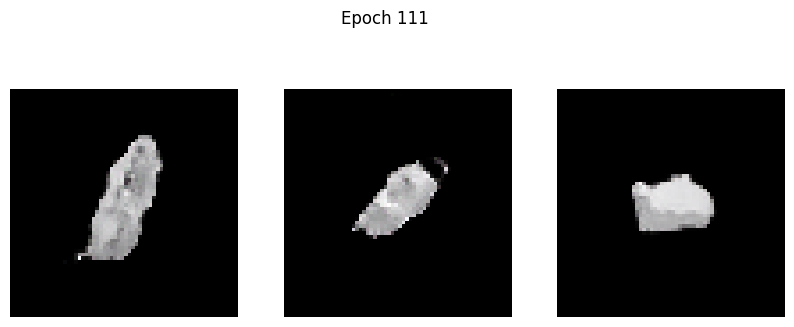

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2267 - g_loss: 2.6702
Epoch 112/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1776 - g_loss: 2.5447

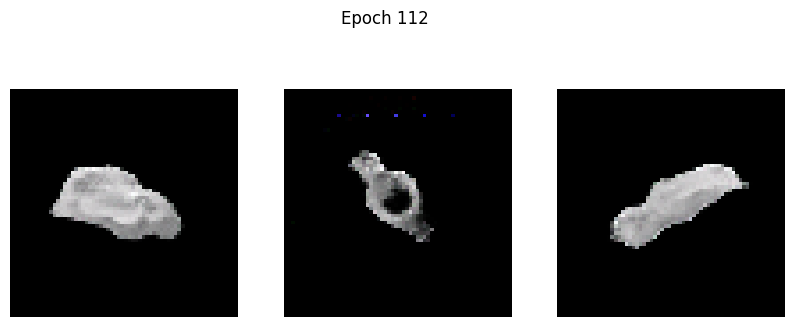

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1778 - g_loss: 2.5447
Epoch 113/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2288 - g_loss: 2.6505

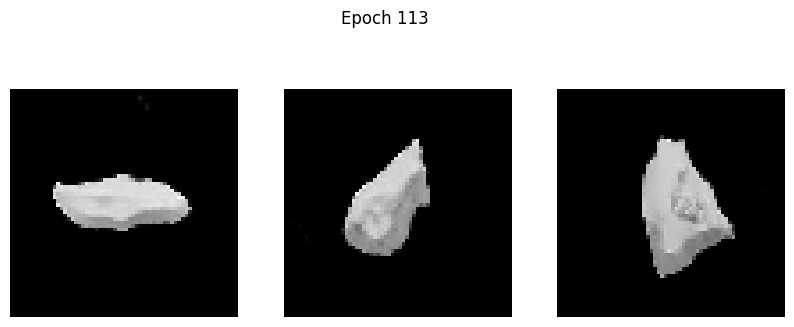

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2289 - g_loss: 2.6504
Epoch 114/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1774 - g_loss: 2.5400

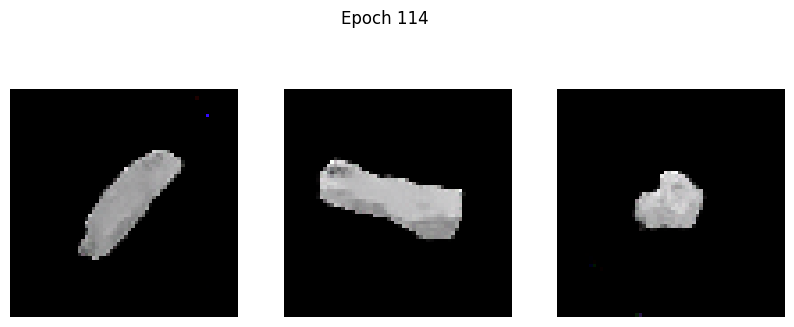

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1777 - g_loss: 2.5407
Epoch 115/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2411 - g_loss: 2.6880

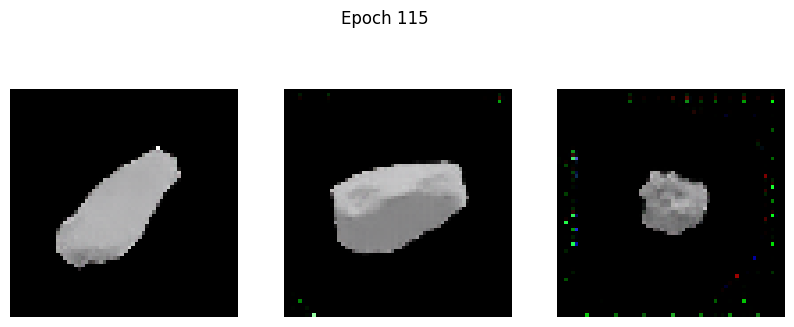

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2407 - g_loss: 2.6872
Epoch 116/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2212 - g_loss: 2.6629

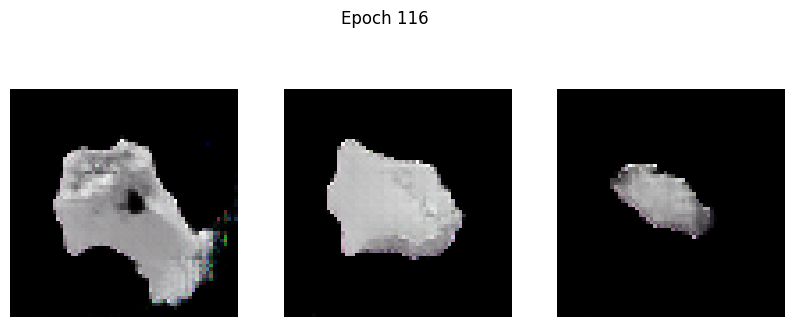

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2237 - g_loss: 2.6645
Epoch 117/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.4045 - g_loss: 2.0622

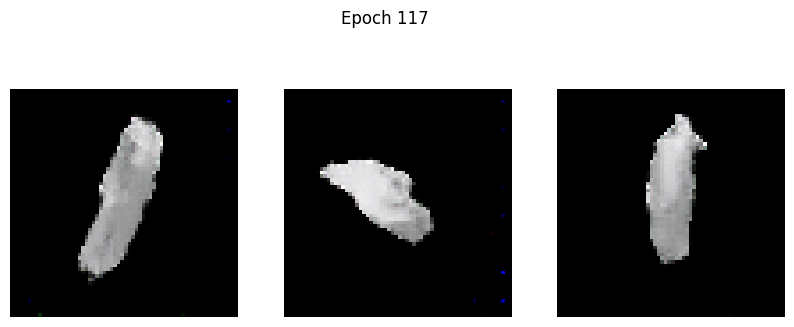

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4035 - g_loss: 2.0629
Epoch 118/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1858 - g_loss: 2.2976

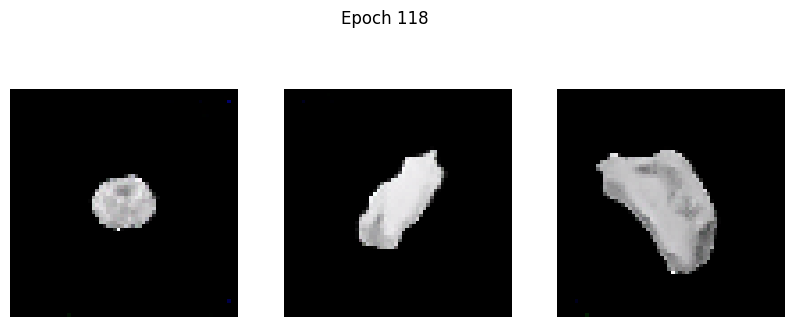

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1859 - g_loss: 2.2979
Epoch 119/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2154 - g_loss: 2.5041

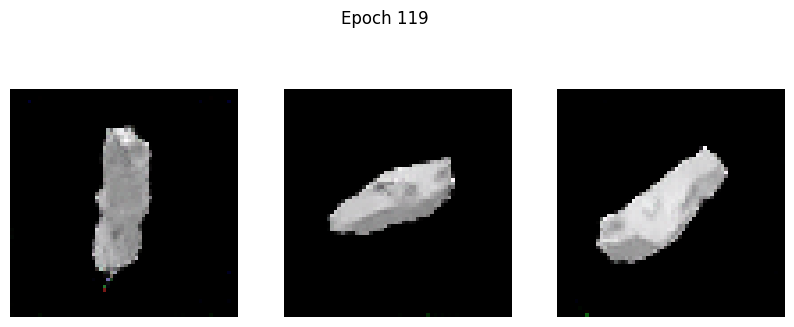

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2152 - g_loss: 2.5037
Epoch 120/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1968 - g_loss: 2.5908

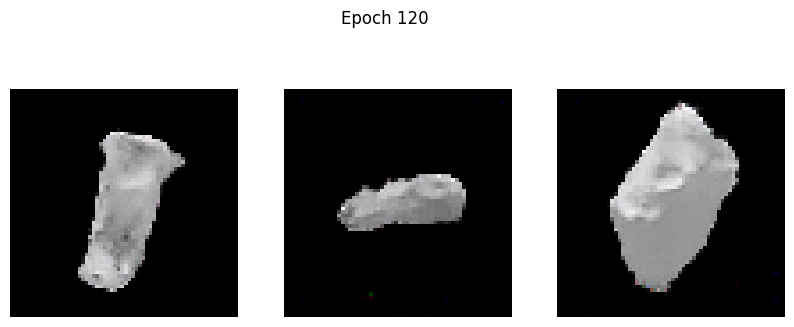

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1971 - g_loss: 2.5909
Epoch 121/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1813 - g_loss: 2.5839

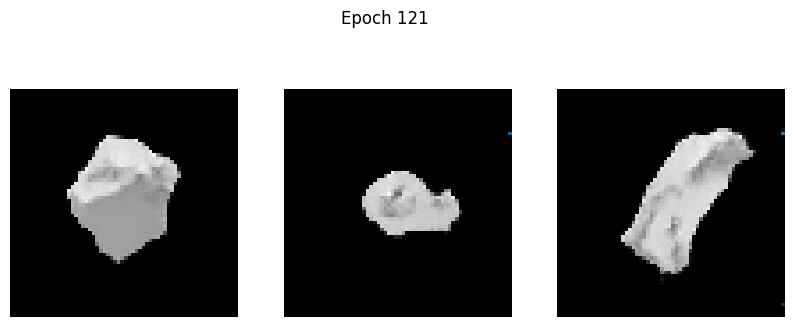

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1813 - g_loss: 2.5838
Epoch 122/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2269 - g_loss: 2.6861

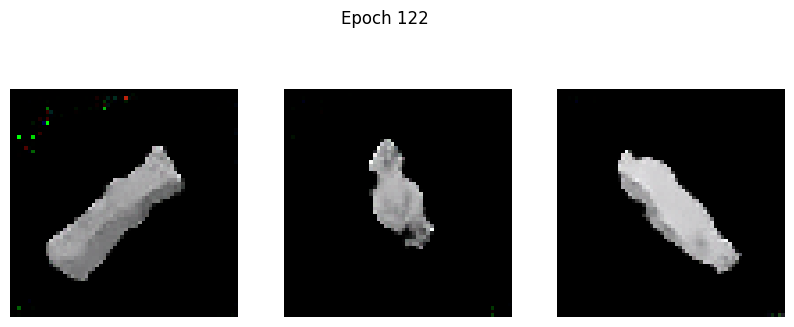

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2270 - g_loss: 2.6859
Epoch 123/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1811 - g_loss: 2.6526

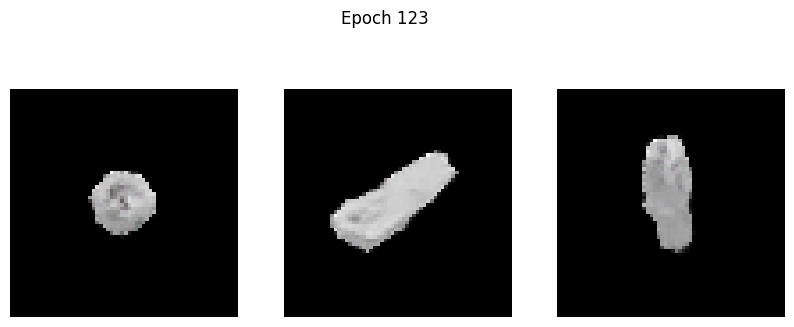

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1811 - g_loss: 2.6524
Epoch 124/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1870 - g_loss: 2.7373

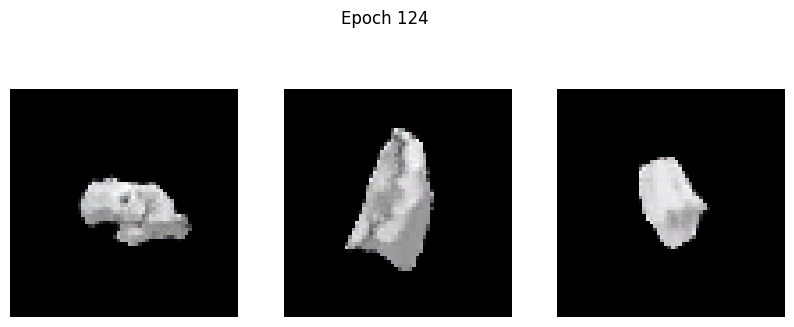

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1875 - g_loss: 2.7373
Epoch 125/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1666 - g_loss: 2.5876

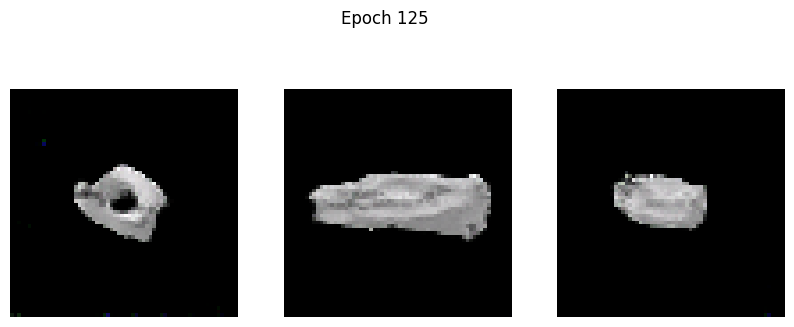

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1666 - g_loss: 2.5879
Epoch 126/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2253 - g_loss: 2.7295

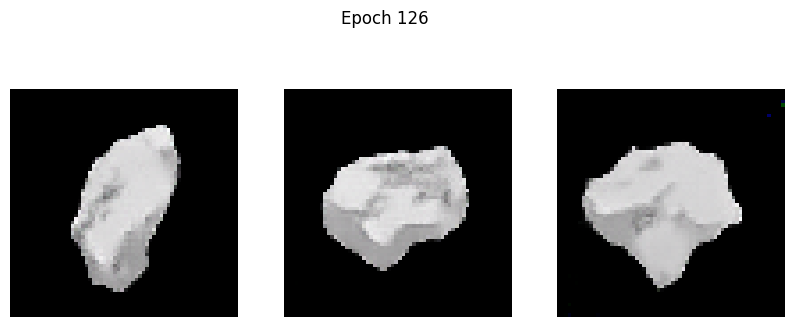

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2253 - g_loss: 2.7294
Epoch 127/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1878 - g_loss: 2.6652

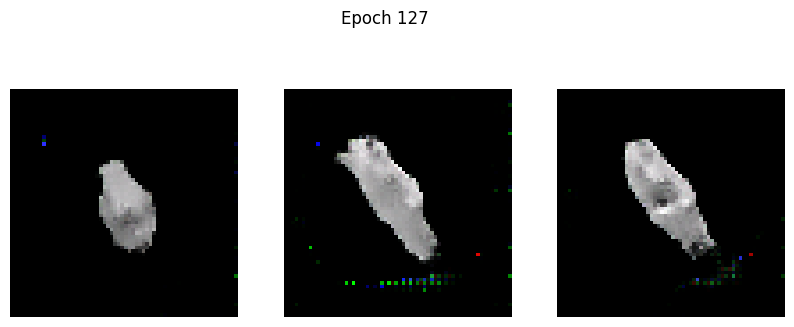

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1887 - g_loss: 2.6661
Epoch 128/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1949 - g_loss: 2.5765

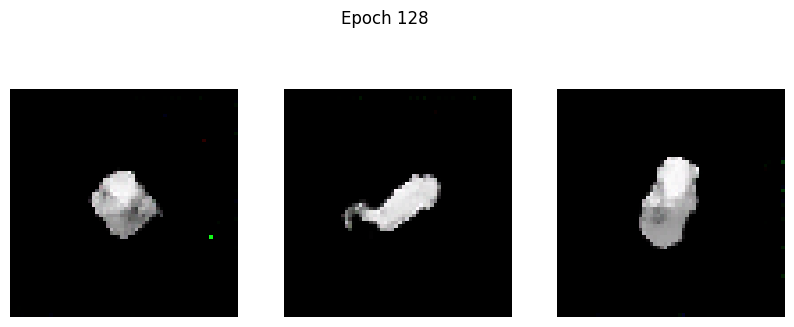

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1948 - g_loss: 2.5768
Epoch 129/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1657 - g_loss: 2.6347

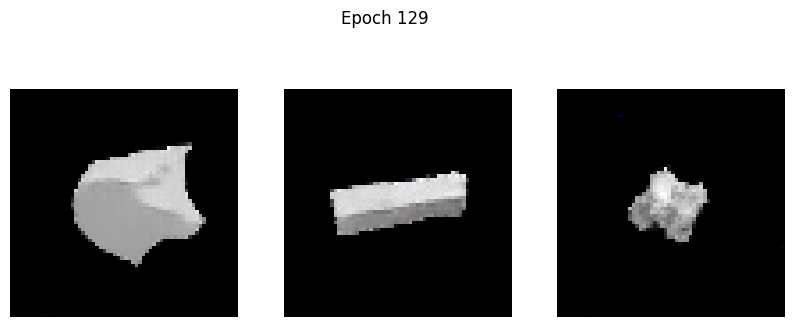

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1657 - g_loss: 2.6353
Epoch 130/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2098 - g_loss: 2.8203

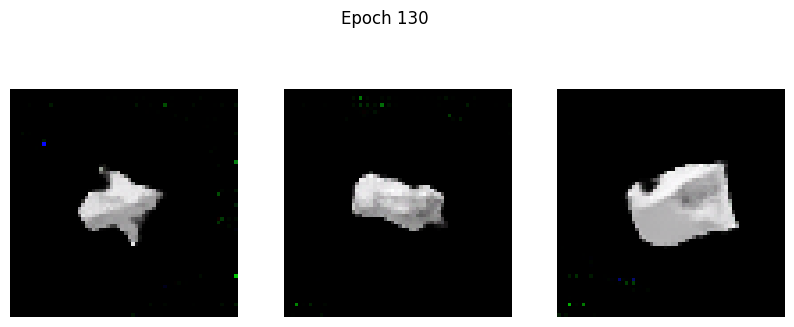

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2102 - g_loss: 2.8205
Epoch 131/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1650 - g_loss: 2.6730

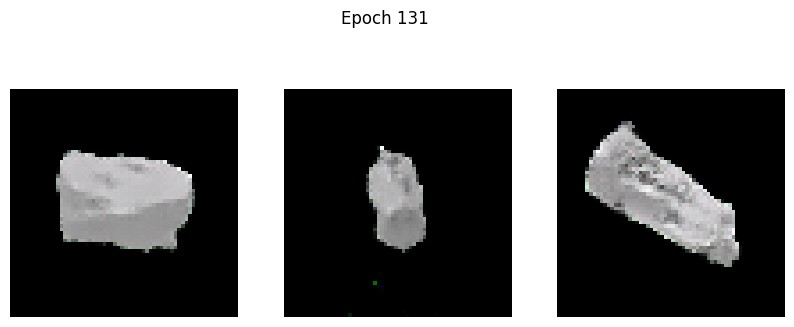

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1659 - g_loss: 2.6744
Epoch 132/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2403 - g_loss: 2.7055

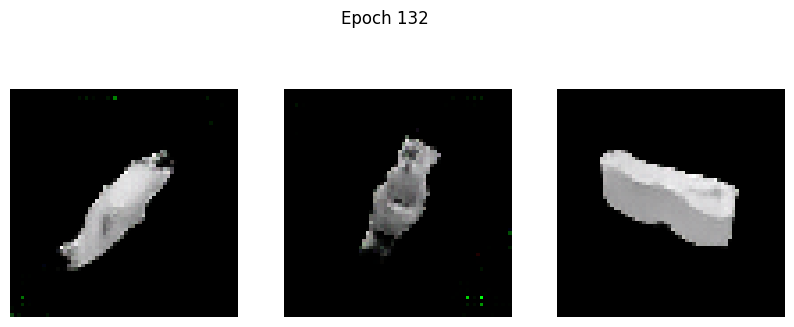

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2397 - g_loss: 2.7048
Epoch 133/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1599 - g_loss: 2.7269

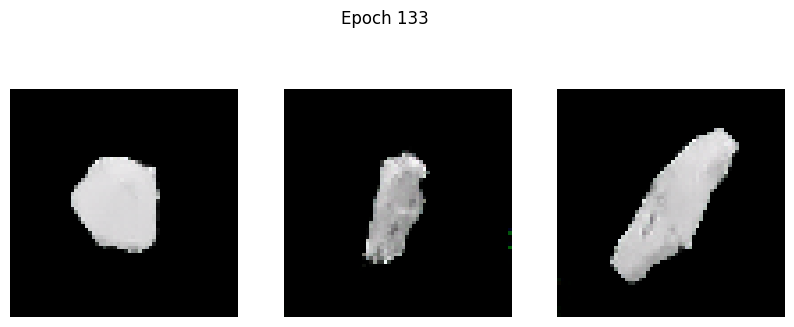

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1604 - g_loss: 2.7277
Epoch 134/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2041 - g_loss: 2.7634

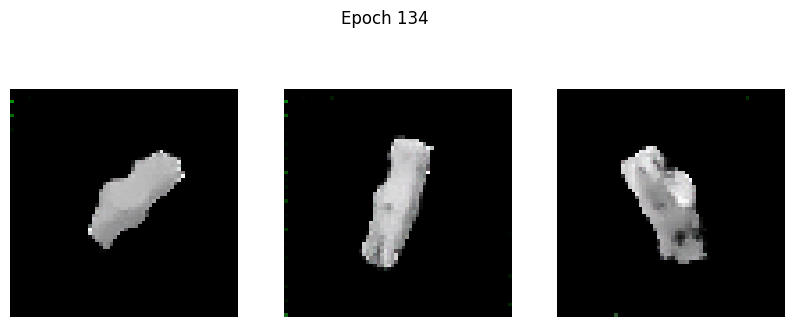

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2037 - g_loss: 2.7626
Epoch 135/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1639 - g_loss: 2.7990

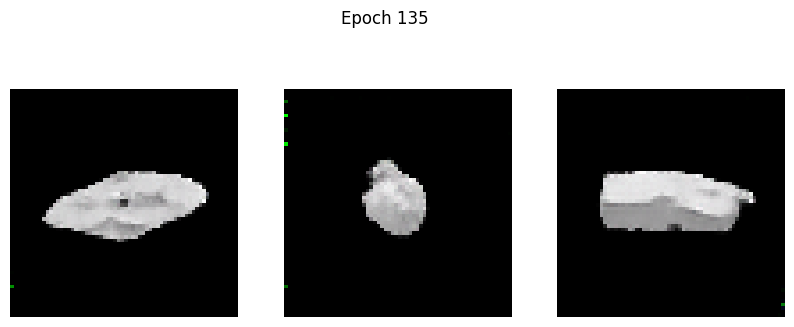

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1642 - g_loss: 2.7992
Epoch 136/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1918 - g_loss: 2.8493

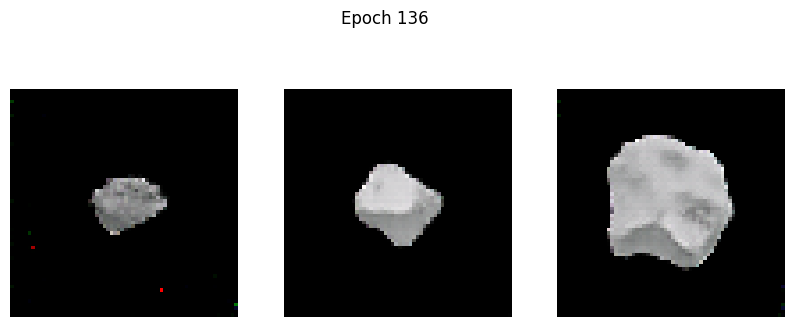

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1937 - g_loss: 2.8523
Epoch 137/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2451 - g_loss: 2.7128

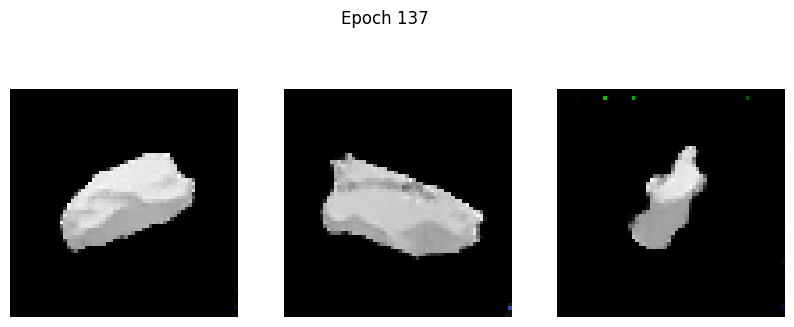

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2446 - g_loss: 2.7120
Epoch 138/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1550 - g_loss: 2.6918

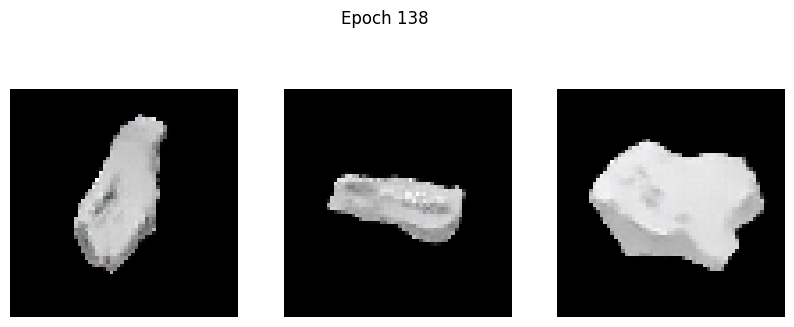

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1550 - g_loss: 2.6920
Epoch 139/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1678 - g_loss: 2.7942

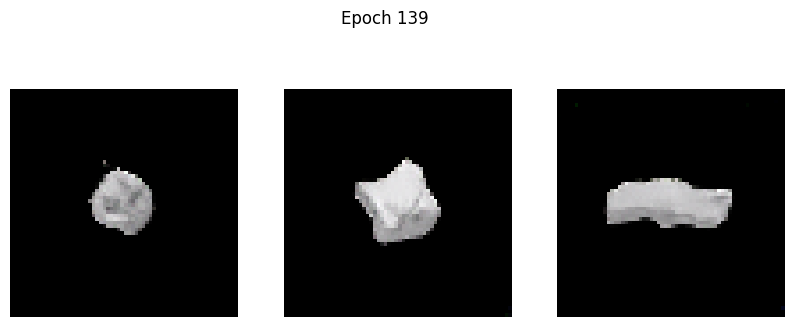

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.1677 - g_loss: 2.7937
Epoch 140/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1705 - g_loss: 2.8017

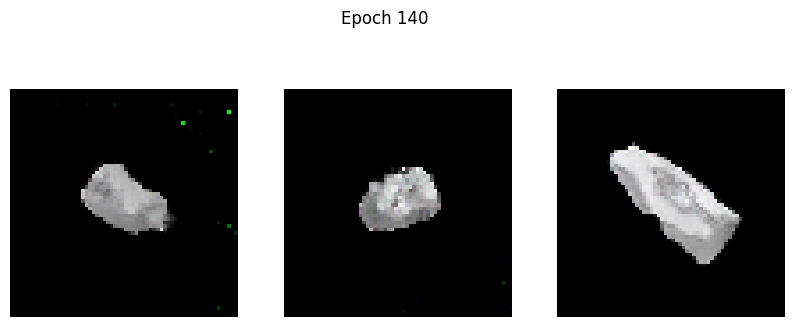

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1705 - g_loss: 2.8018
Epoch 141/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.2542 - g_loss: 2.8917

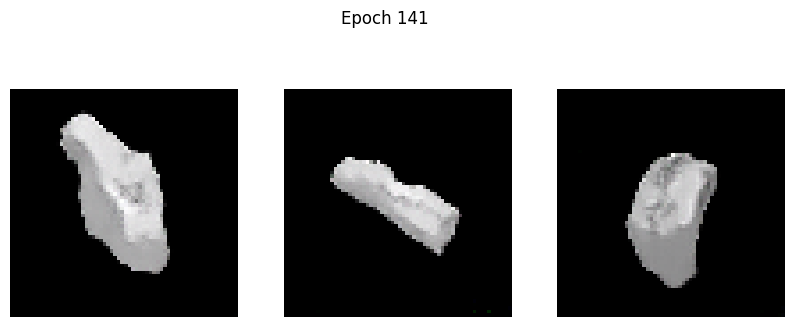

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.2536 - g_loss: 2.8911
Epoch 142/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2408 - g_loss: 2.9986

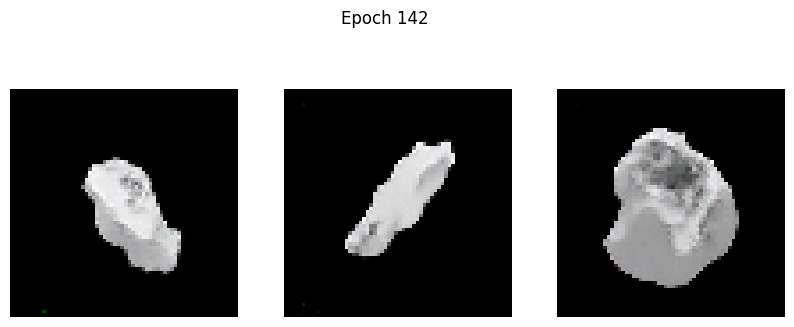

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.2410 - g_loss: 2.9981
Epoch 143/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1622 - g_loss: 2.8467

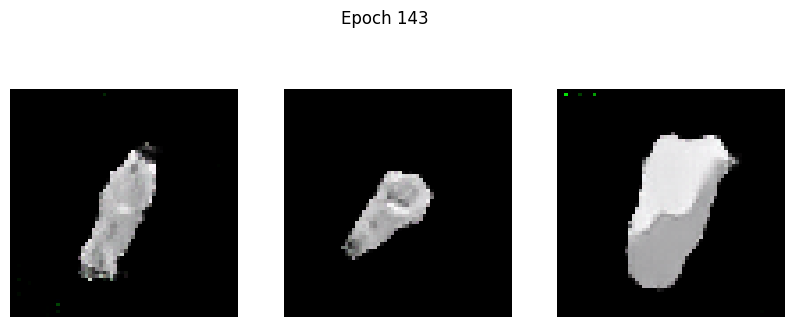

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1622 - g_loss: 2.8469
Epoch 144/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1925 - g_loss: 2.8571

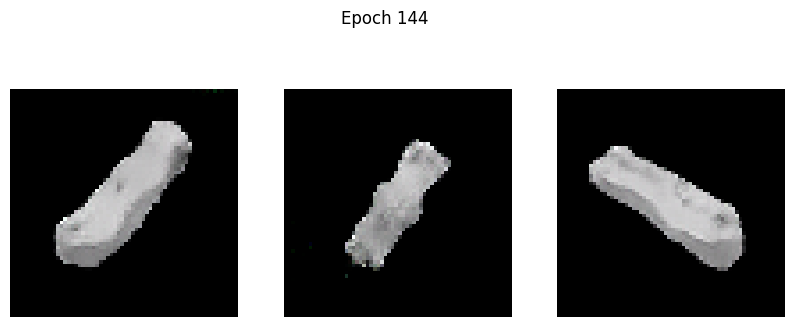

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1929 - g_loss: 2.8575
Epoch 145/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2457 - g_loss: 2.9104

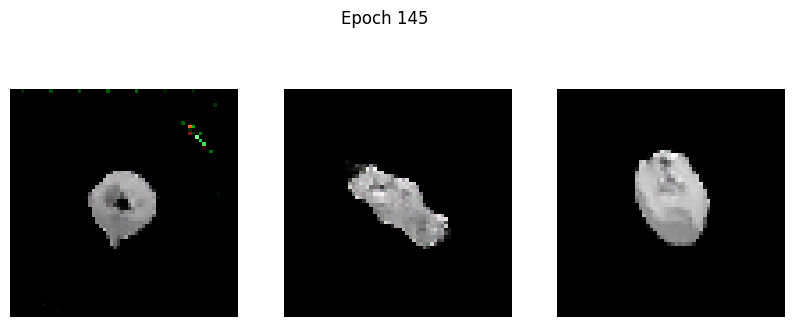

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2461 - g_loss: 2.9103
Epoch 146/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1461 - g_loss: 2.7426

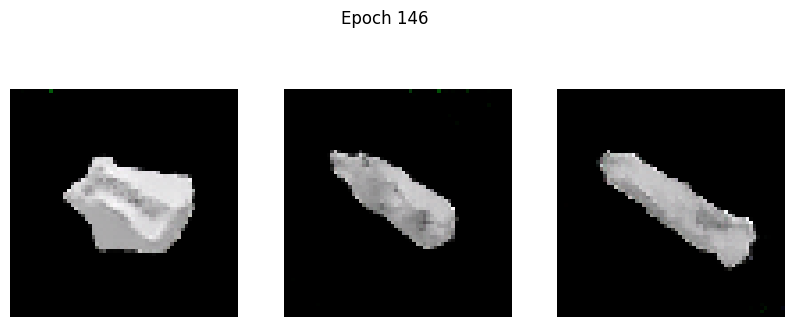

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1461 - g_loss: 2.7430
Epoch 147/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1483 - g_loss: 2.8653

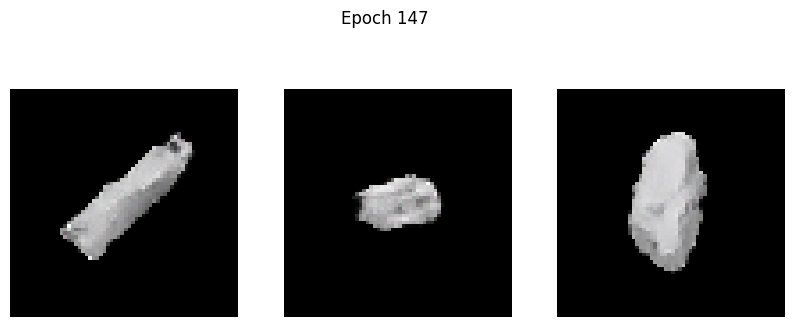

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.1483 - g_loss: 2.8659
Epoch 148/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2173 - g_loss: 3.1269

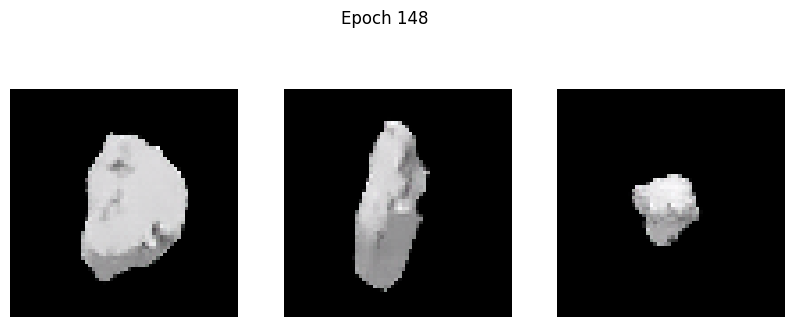

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - d_loss: 0.2172 - g_loss: 3.1259
Epoch 149/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1662 - g_loss: 2.9233

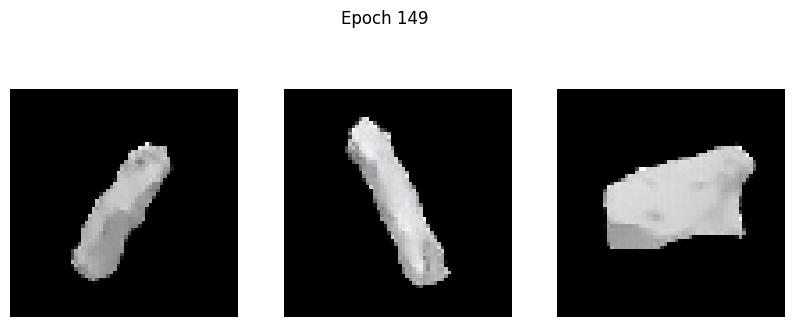

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1663 - g_loss: 2.9233
Epoch 150/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1559 - g_loss: 2.9208

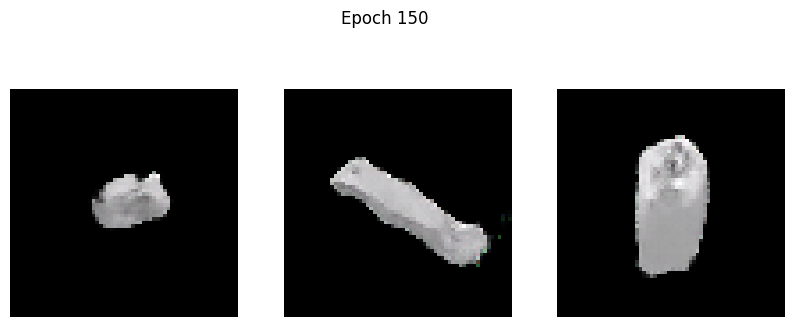

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1559 - g_loss: 2.9208
Epoch 151/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2540 - g_loss: 3.1418

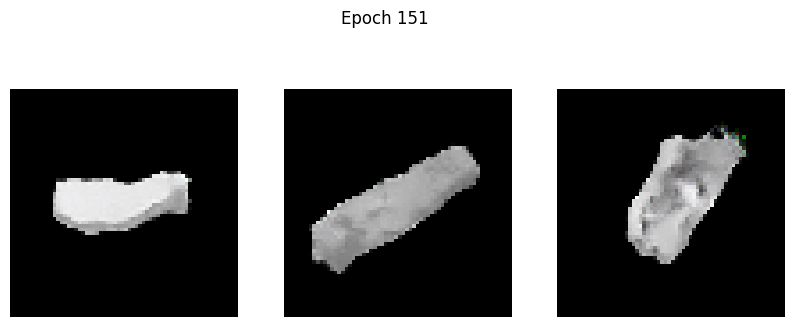

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.2534 - g_loss: 3.1401
Epoch 152/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1511 - g_loss: 2.9501

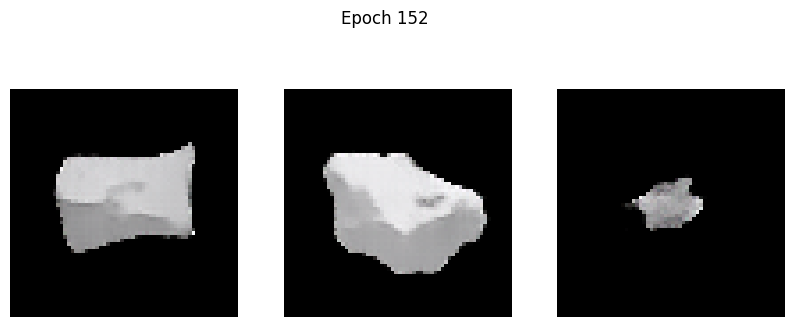

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1517 - g_loss: 2.9501
Epoch 153/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2185 - g_loss: 2.9856

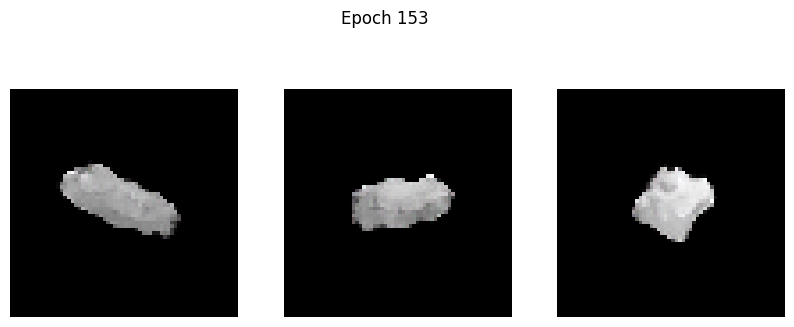

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2189 - g_loss: 2.9859
Epoch 154/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1295 - g_loss: 2.8829

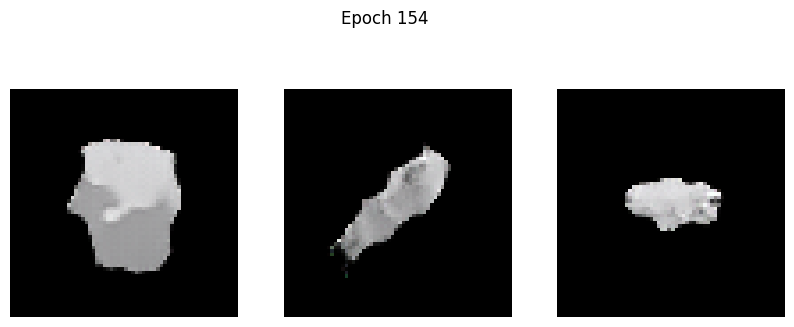

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1295 - g_loss: 2.8829
Epoch 155/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1728 - g_loss: 2.9090

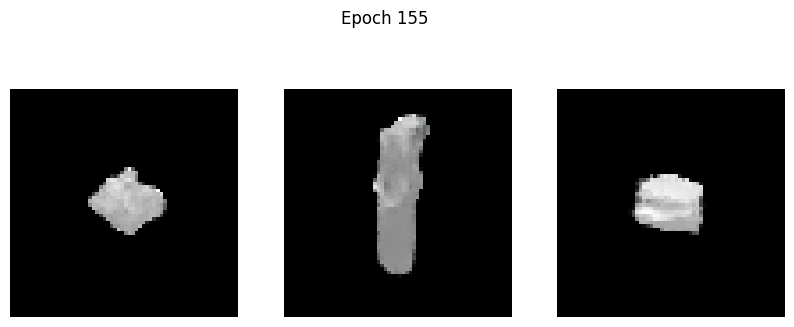

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1727 - g_loss: 2.9092
Epoch 156/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1623 - g_loss: 2.9370

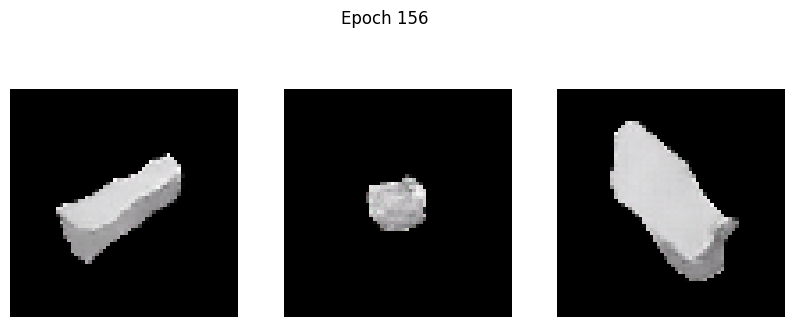

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1624 - g_loss: 2.9375
Epoch 157/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1396 - g_loss: 3.0635

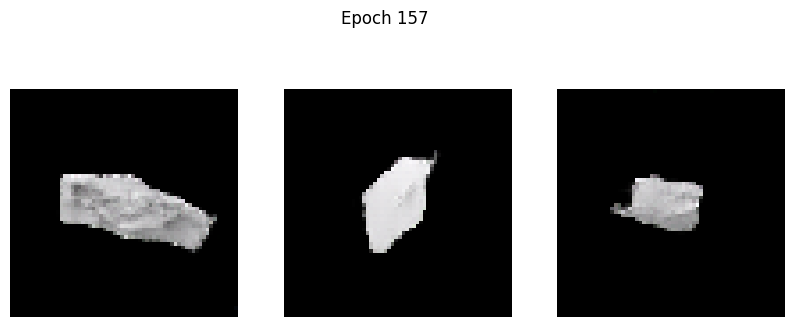

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1399 - g_loss: 3.0635
Epoch 158/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1639 - g_loss: 3.0528

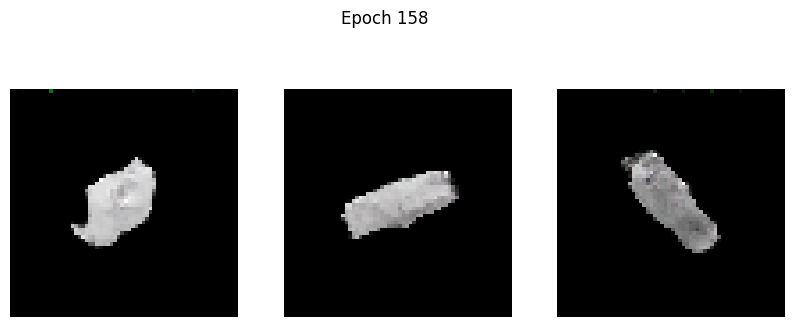

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1642 - g_loss: 3.0529
Epoch 159/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1493 - g_loss: 2.9881

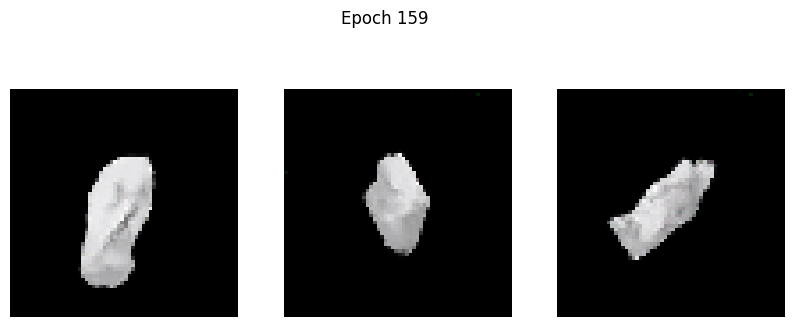

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1492 - g_loss: 2.9881
Epoch 160/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2778 - g_loss: 3.2091

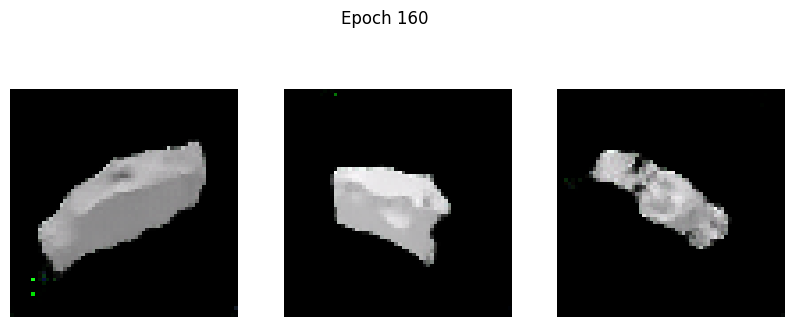

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2775 - g_loss: 3.2082
Epoch 161/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1536 - g_loss: 3.0127

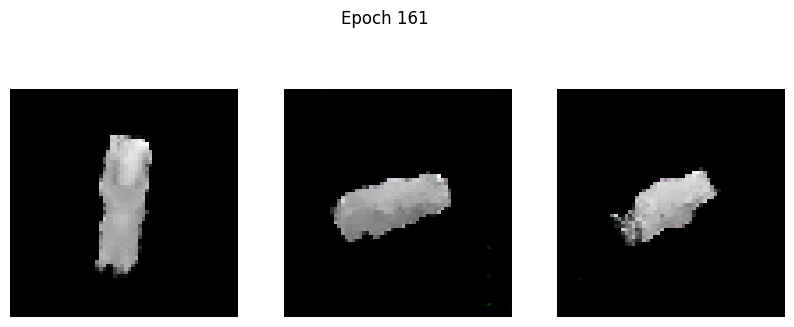

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1538 - g_loss: 3.0131
Epoch 162/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1699 - g_loss: 3.1287

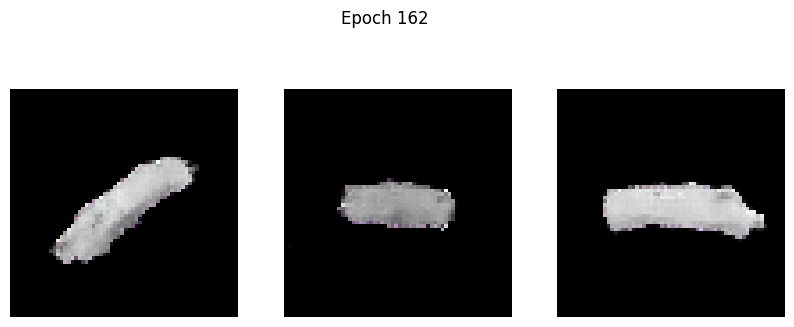

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.1718 - g_loss: 3.1314
Epoch 163/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.3195 - g_loss: 2.7539

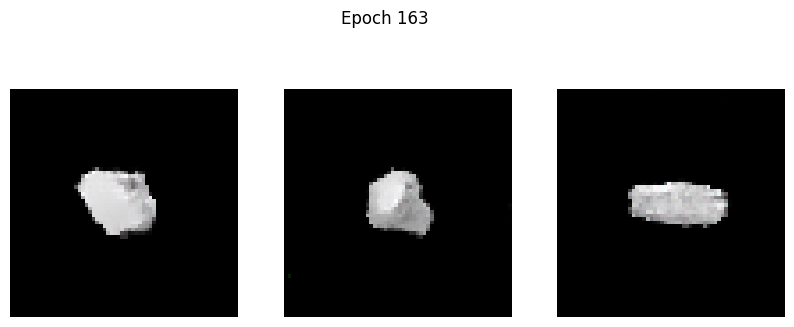

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.3184 - g_loss: 2.7540
Epoch 164/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1260 - g_loss: 2.8925

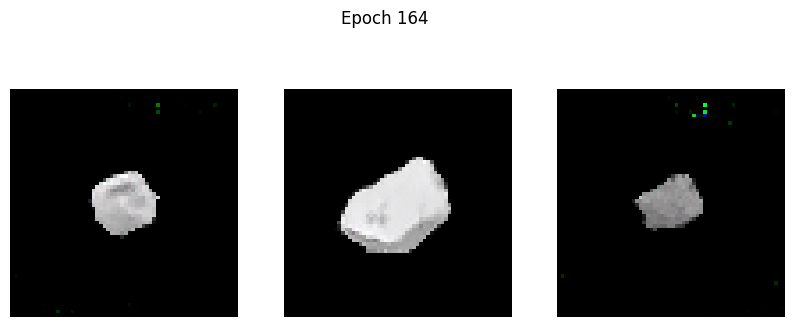

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.1260 - g_loss: 2.8930
Epoch 165/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1355 - g_loss: 2.9804

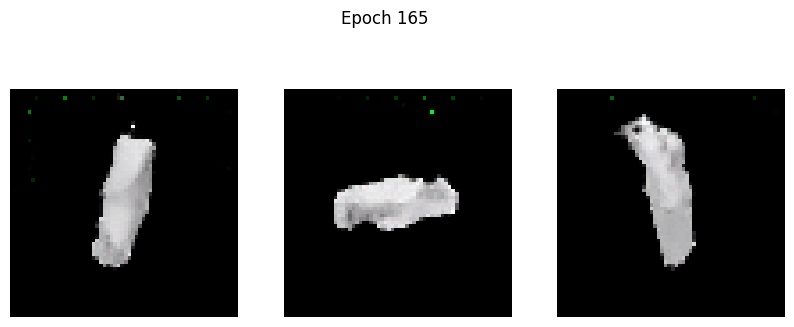

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1355 - g_loss: 2.9803
Epoch 166/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1896 - g_loss: 3.1503

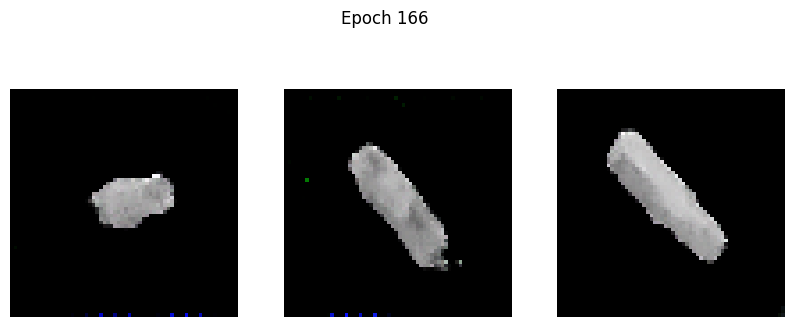

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1892 - g_loss: 3.1494
Epoch 167/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1672 - g_loss: 3.0749

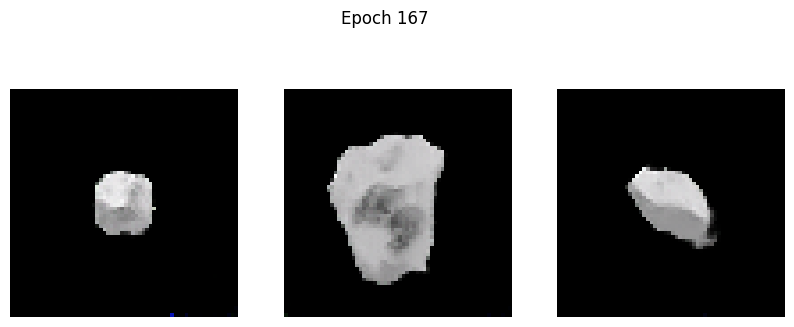

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1674 - g_loss: 3.0752
Epoch 168/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1261 - g_loss: 3.0773

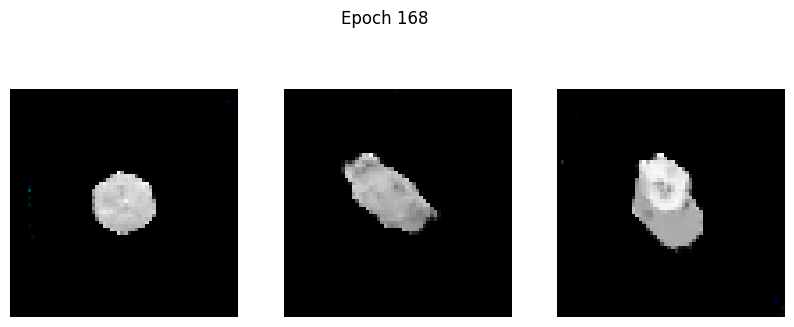

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1262 - g_loss: 3.0776
Epoch 169/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1365 - g_loss: 3.1735

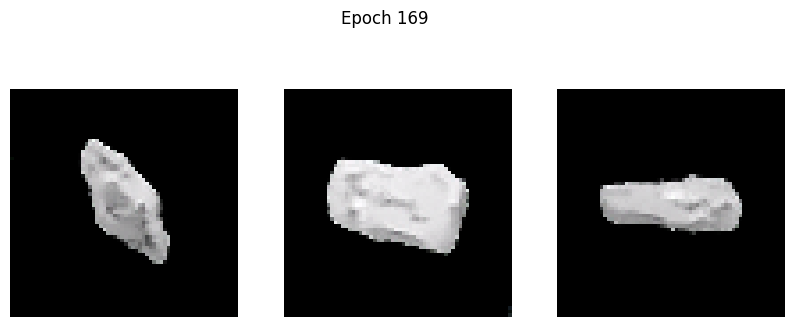

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1366 - g_loss: 3.1732
Epoch 170/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2038 - g_loss: 3.2288

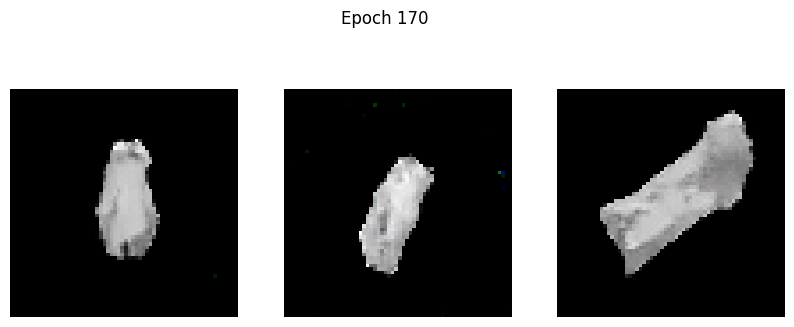

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2054 - g_loss: 3.2317
Epoch 171/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1424 - g_loss: 2.9604

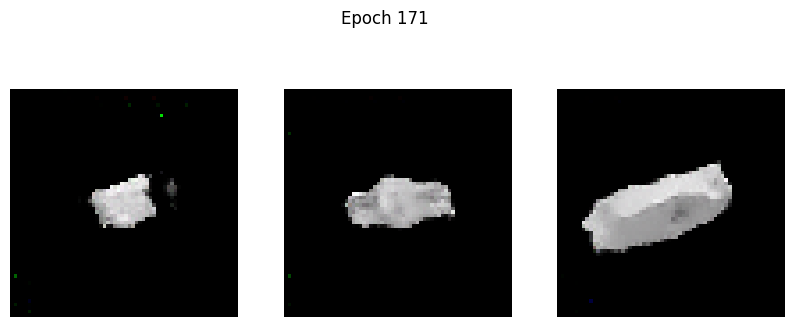

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1423 - g_loss: 2.9605
Epoch 172/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1256 - g_loss: 2.9585

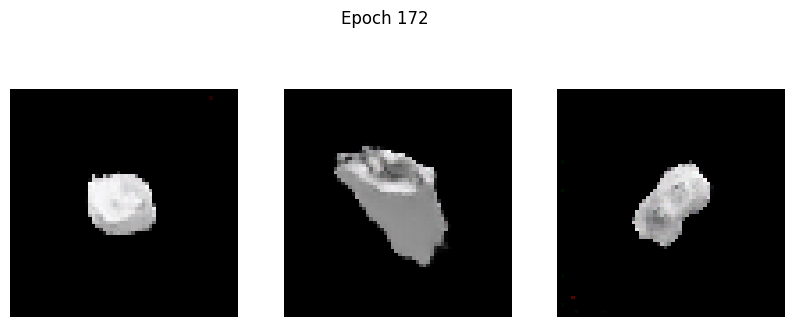

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1256 - g_loss: 2.9590
Epoch 173/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1668 - g_loss: 3.1564

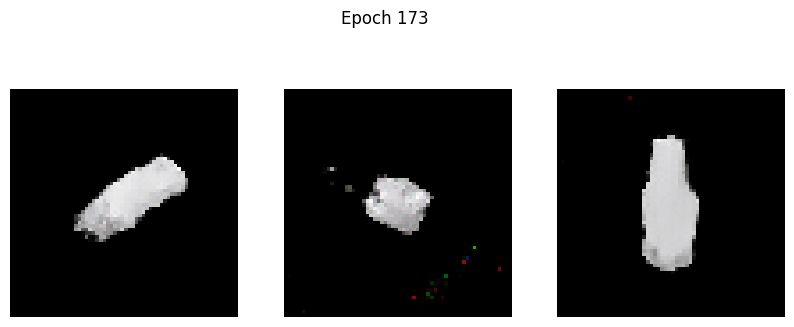

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1667 - g_loss: 3.1561
Epoch 174/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1271 - g_loss: 3.1178

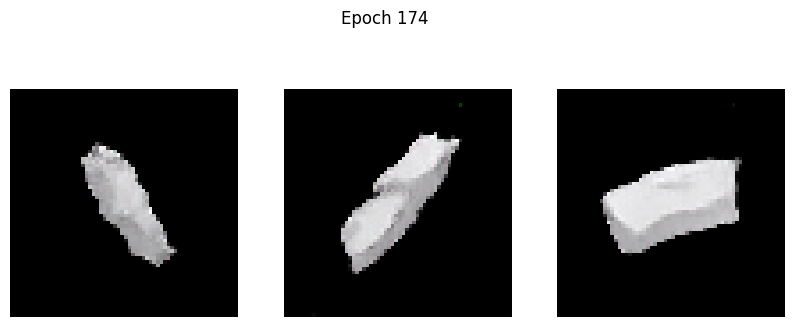

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1271 - g_loss: 3.1179
Epoch 175/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1618 - g_loss: 3.2443

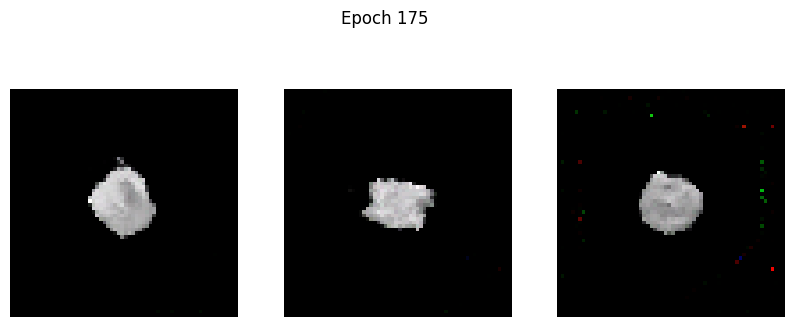

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1622 - g_loss: 3.2444
Epoch 176/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1442 - g_loss: 3.1815

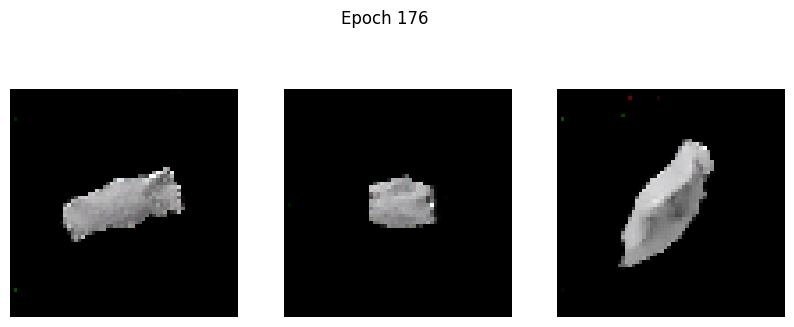

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1442 - g_loss: 3.1813
Epoch 177/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1366 - g_loss: 3.2082

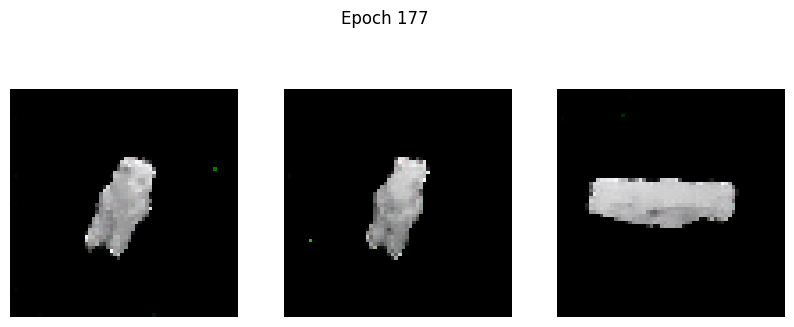

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1368 - g_loss: 3.2082
Epoch 178/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1549 - g_loss: 3.2165

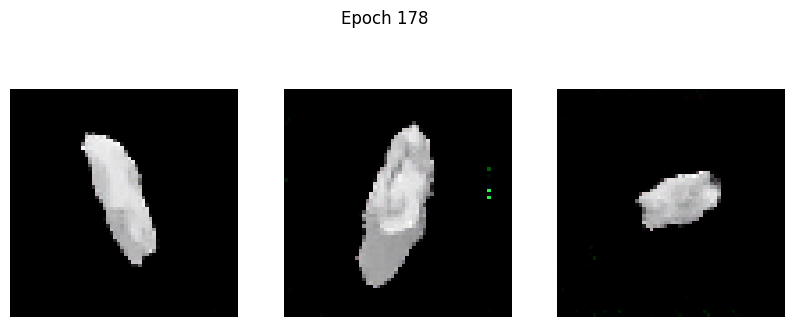

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1549 - g_loss: 3.2162
Epoch 179/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1542 - g_loss: 3.2730

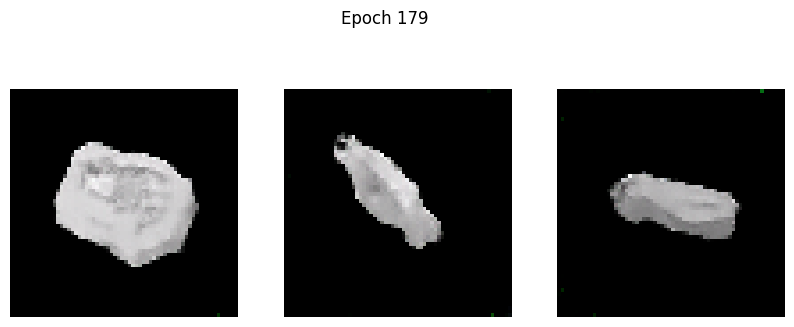

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1543 - g_loss: 3.2728
Epoch 180/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1138 - g_loss: 3.2181

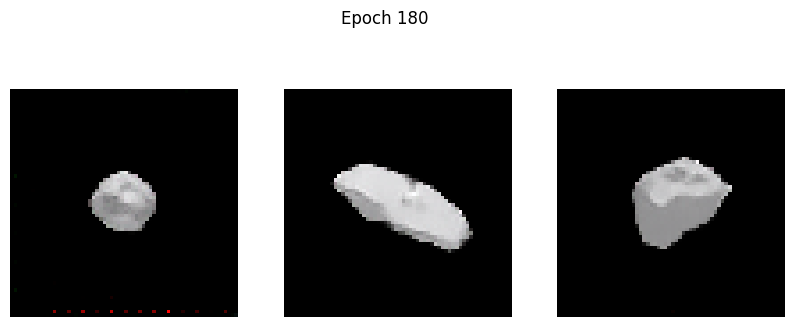

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.1139 - g_loss: 3.2184
Epoch 181/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.2820 - g_loss: 3.3910

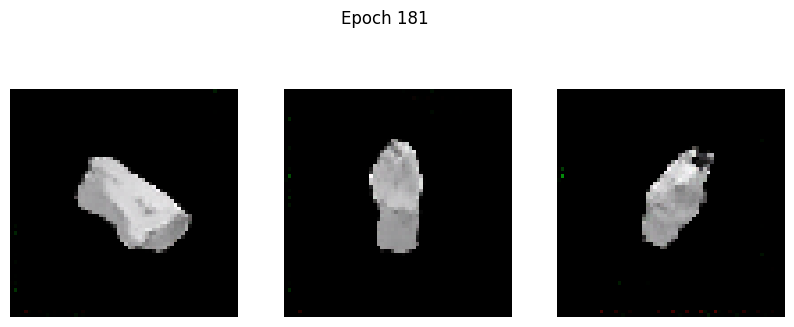

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2824 - g_loss: 3.3911
Epoch 182/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1333 - g_loss: 3.1704

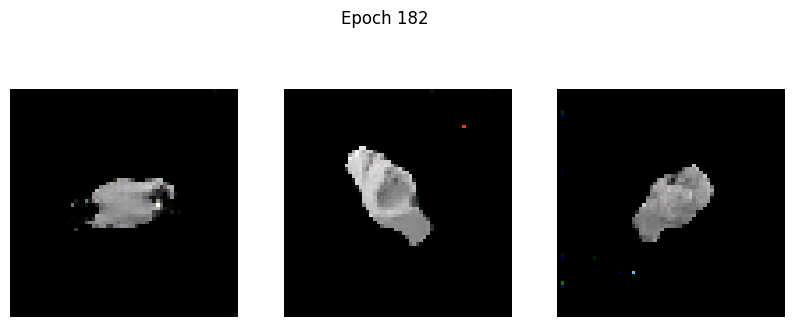

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.1332 - g_loss: 3.1696
Epoch 183/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1252 - g_loss: 3.2237

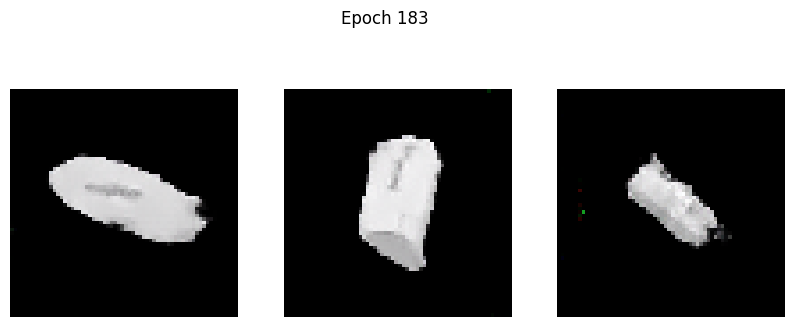

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1252 - g_loss: 3.2236
Epoch 184/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1390 - g_loss: 3.2474

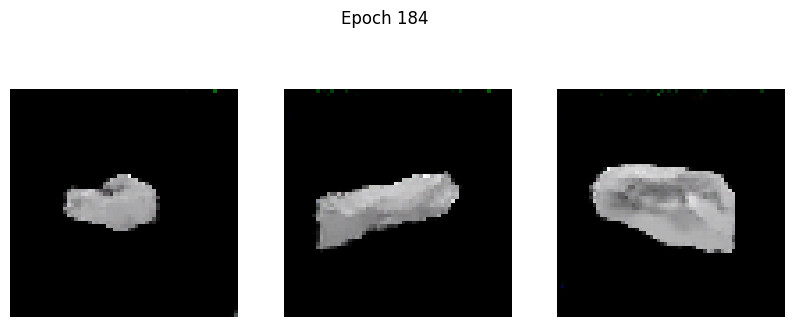

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1390 - g_loss: 3.2475
Epoch 185/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2698 - g_loss: 3.4426

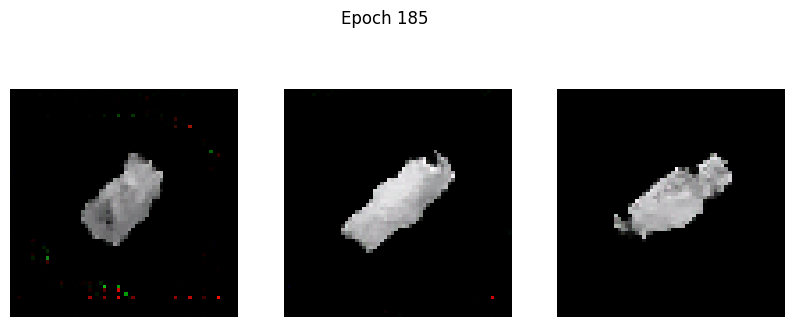

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2696 - g_loss: 3.4411
Epoch 186/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1141 - g_loss: 3.2075

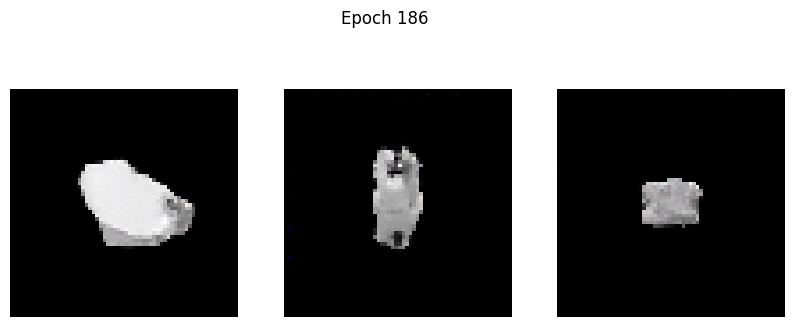

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1141 - g_loss: 3.2079
Epoch 187/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3950 - g_loss: 3.3126

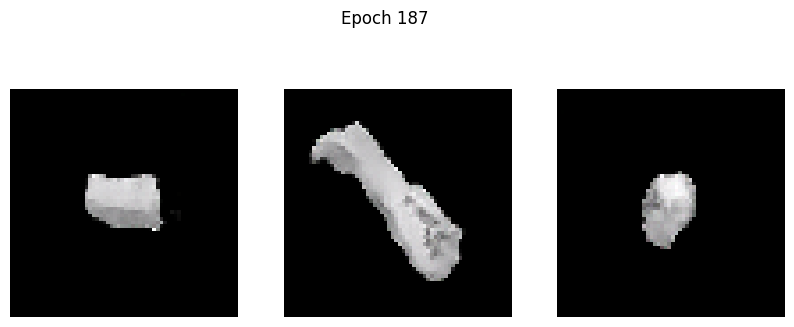

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3937 - g_loss: 3.3116
Epoch 188/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1207 - g_loss: 3.1965

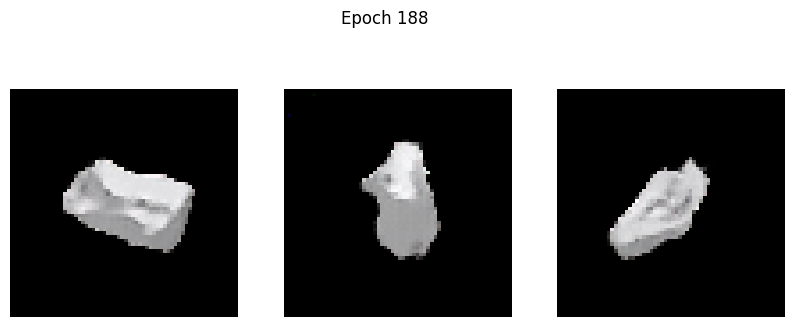

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1207 - g_loss: 3.1966
Epoch 189/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1122 - g_loss: 3.2654

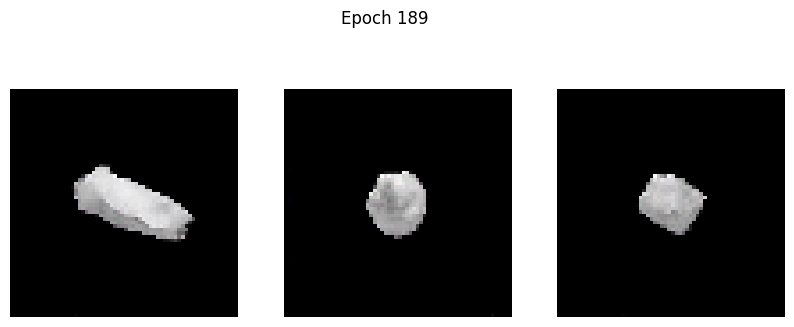

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1123 - g_loss: 3.2656
Epoch 190/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1170 - g_loss: 3.3174

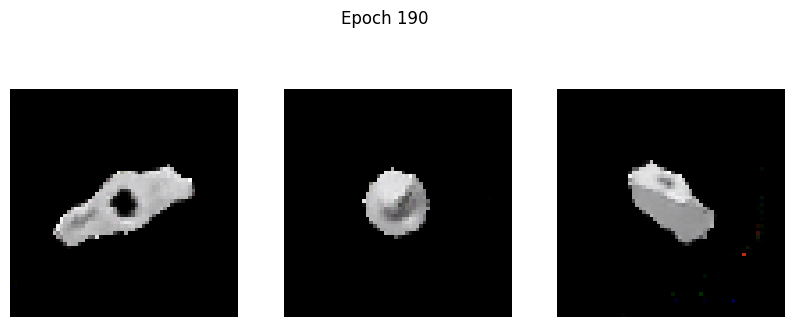

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1169 - g_loss: 3.3173
Epoch 191/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.3054 - g_loss: 3.5713

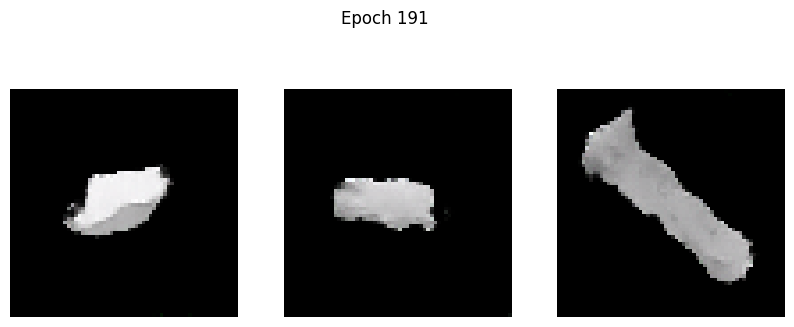

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3047 - g_loss: 3.5697
Epoch 192/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1215 - g_loss: 3.2473

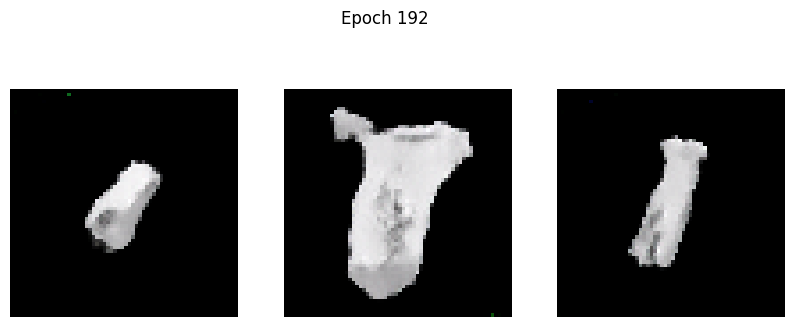

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1215 - g_loss: 3.2476
Epoch 193/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1349 - g_loss: 3.4341

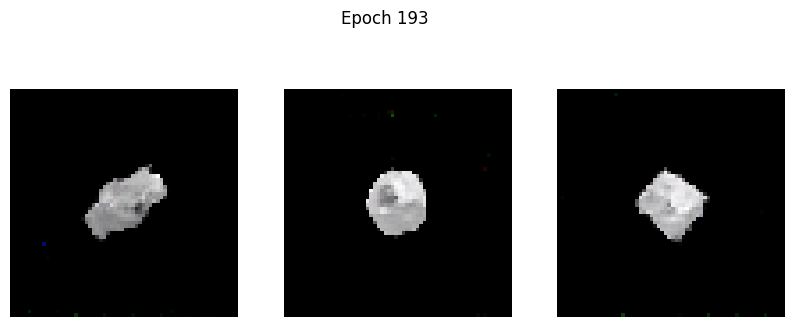

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1350 - g_loss: 3.4337
Epoch 194/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1814 - g_loss: 3.3456

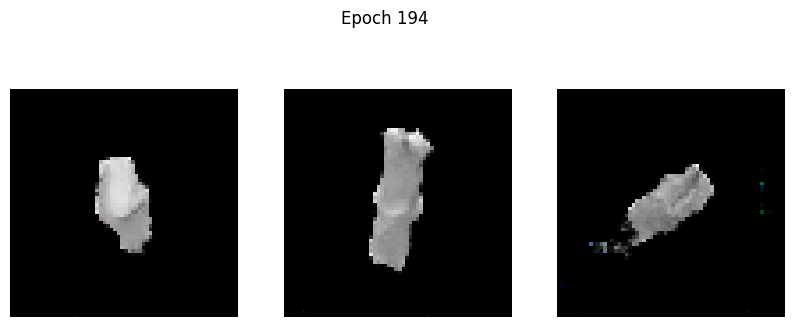

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1817 - g_loss: 3.3462
Epoch 195/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1045 - g_loss: 3.2620

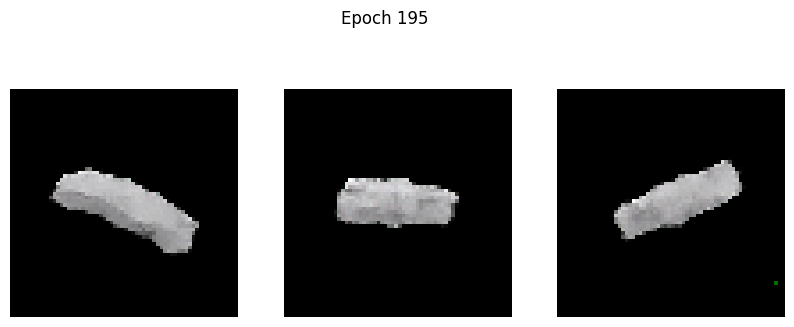

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1046 - g_loss: 3.2626
Epoch 196/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1146 - g_loss: 3.2782

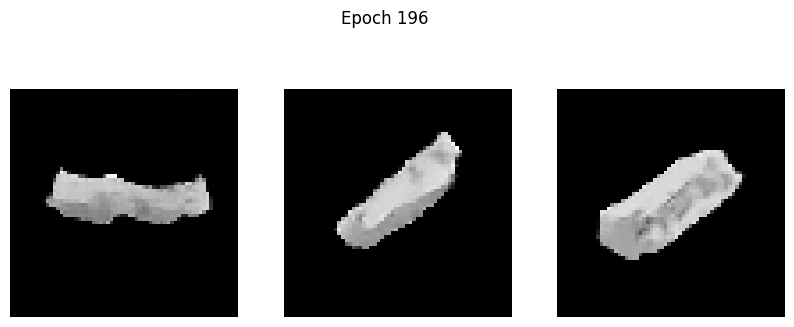

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1147 - g_loss: 3.2786
Epoch 197/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1052 - g_loss: 3.4529

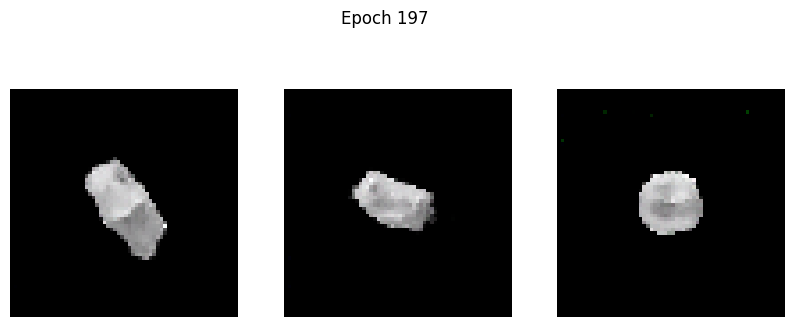

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1054 - g_loss: 3.4524
Epoch 198/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1244 - g_loss: 3.3313

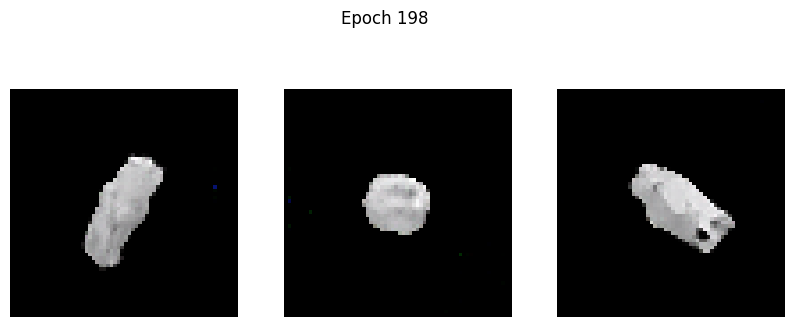

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1245 - g_loss: 3.3318
Epoch 199/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1504 - g_loss: 3.4733

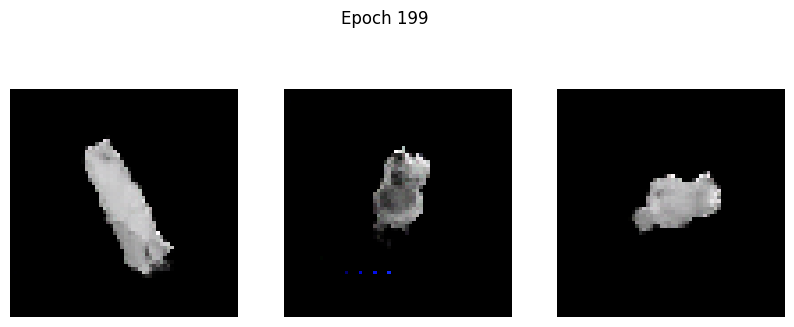

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1508 - g_loss: 3.4736
Epoch 200/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2537 - g_loss: 3.6538

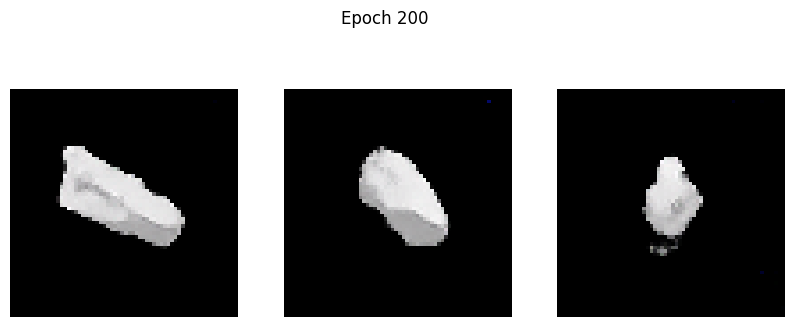

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2545 - g_loss: 3.6539


In [8]:
# Hyperparameters
EPOCHS = 200  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)